# Lab Five: Wide and Deep Network Architectures



# 1. Business Understanding
*In this lab, you will select a prediction task to perform on your dataset, evaluate two different deep learning architectures and tune hyper-parameters for each architecture. If any part of the assignment is not clear, ask the instructor to clarify.*

*This report is worth 10% of the final grade. Please upload a report (one per team) with all code used, visualizations, and text in a rendered Jupyter notebook. Any visualizations that cannot be embedded in the notebook, please provide screenshots of the output. The results should be reproducible using your report. Please carefully describe every assumption and every step in your report.*

**Dataset Selection**

*Select a dataset similarly to lab one. That is, the dataset must be table data and must have categorical features. In terms of generalization performance, it is helpful to have a large dataset for building a wide and deep network. It is also helpful to have many different categorical features to create the embeddings and cross-product embeddings. It is fine to perform binary classification, multi-class classification, or regression. You are NOT allowed to use the census (i.e., Adult) dataset that was given as an example in class.*

For this lab, we will be using the dataset "Full Pokemon Stats, Abilities, and More" compiled by Kaggle user Elijahi Adusi. This data set was scraped from https://pokemondb.net/pokedex/all and contains every Pokemon's name, types, statistics, and other characteristics of each species. We chose this data set instead of the data set we have been using for previous labs because our previous data set contains too many missing values in many different categories to create an effective wide and deep network. Additionally, this data set works well because it has many different categorical variables to create our embeddings and cross-product embeddings. Our prediction task for this data set is to predict whether or not an unknown Pokemon is considered "Legendary" based on its given characteristics.

# 2 Dataset Preparation
In this lab, we will use a new dataset containing a list of existing pokemon.

Dataset: Full Pokemon Stats, Abilities, and more data

Reference: https://www.kaggle.com/datasets/elijahiadusi/full-pokemon-stats-abilities-and-more-data?resource=download&select=Pokemon_Data.csv

We later modified this dataset to additionally have randomly generated pokemon in order to ensure a large enough dataset. To do ensure that the pokemon generated are as close to being "legitimate" as possible, each new pokemon's stats are randomly generated in increments of 10 up to a limit of 15. Each new pokemon will only get existing typing and abilities. Pokemon with a total stat of over 600 will only recieve abilities belonging to existing legendary pokemon. New pokemon will be randomized to be part of a evolution chain of 2-3 pokemon, where they will be part of the same pokemon species. Pokemon with a total stat of exactly 600 will be randomized to be either legendary, sub legendary, or mythical. The code to generate these new pokemon are provided below.

In [731]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import missingno as mn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import os
import pprint as pp
from copy import deepcopy
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn import metrics as mt
import tensorflow as tf
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam, SGD
from sklearn.pipeline import Pipeline
from tensorflow.keras.metrics import Precision
from sklearn.metrics import make_scorer, accuracy_score, precision_score, f1_score
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, concatenate, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.utils import FeatureSpace
from tensorflow.keras import backend as K
import sys
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
warnings.filterwarnings("ignore")

In [732]:
df = pd.read_csv('/content/sample_data/Pokemon_Data.csv')

In [733]:
import pandas as pd
from numpy.random import choice, randint
import string

# Function to generate a random name for Pokémon or species
def random_name():
    length = randint(3, 10)
    name = ''.join(choice(list(string.ascii_uppercase + string.ascii_lowercase)) for _ in range(length))
    return name.capitalize()

# Function to generate random Pokémon stats in increments of 10
def generate_stats():
    stats = {}
    for stat in ['HP', 'Attack', 'Defense', 'Sp.Atk', 'Sp.Def', 'Speed']:
        stats[stat] = randint(1, 15) * 10
    return stats

# Optional value generator for Second Ability, Egg Group 2, and Hidden Ability
def optional_value(values, chance=1.0):
    return choice([None] + list(values)) if randint(100) < chance * 100 else None

# Function to generate random Pokémon with constraints
def generate_pokemon(pokemon_number, existing_types, abilities, egg_groups, species, existing_generations, hidden_abilities):
    name = random_name()
    stats = generate_stats()
    stat_total = sum(stats.values())

    # Ensure stat total does not exceed 720
    while stat_total > 720:
        stats = generate_stats()
        stat_total = sum(stats.values())

    # Determine if the Pokémon is legendary, sub-legendary, or mythical
    is_legendary = is_sub_legendary = is_mythical = False
    if stat_total > 600:
        is_legendary = True
    elif stat_total == 600:
        status = choice(['legendary', 'sub_legendary', 'mythical'])
        if status == 'legendary':
            is_legendary = True
        elif status == 'sub_legendary':
            is_sub_legendary = True
        elif status == 'mythical':
            is_mythical = True

    if is_legendary or is_mythical:
        species = f"{random_name()} Pokémon"  # Unique species name for each legendary/mythical

    ability_pool = abilities['legendary'] if is_legendary else abilities['normal']
    egg_group_pool = egg_groups['legendary'] if is_legendary else egg_groups['normal']

    new_pokemon = {
        'Pokemon Number': pokemon_number,
        'Pokemon Name': name,
        'Species': species,
        'Mega': False,
        **stats,
        'Stat Total': stat_total,
        'First Type': choice(existing_types),
        'Second Type': optional_value(existing_types, 0.35),
        'First Ability': choice(ability_pool),
        'Second Ability': optional_value(ability_pool, 0.5),
        'Egg Group 1': choice(egg_group_pool),
        'Egg Group 2': optional_value(egg_group_pool, 0.5),
        'Generation': choice(existing_generations),
        'Hidden Ability': optional_value(hidden_abilities, 0.5),
        'Is Legendary': is_legendary,
        'Is Sub Legendary': is_sub_legendary,
        'Is Mythical': is_mythical
    }
    return new_pokemon

# Function to read existing data, generate new Pokémon, and save to a new CSV
def update_pokemon_dataset(file_path, num_new_pokemon):
    existing_data = pd.read_csv(file_path)
    legendary_data = existing_data[existing_data['Is Legendary']]
    abilities = {
        'normal': pd.concat([existing_data['First Ability'], existing_data['Second Ability']]).dropna().unique(),
        'legendary': pd.concat([legendary_data['First Ability'], legendary_data['Second Ability']]).dropna().unique()
    }
    egg_groups = {
        'normal': pd.concat([existing_data['Egg Group 1'], existing_data['Egg Group 2']]).dropna().unique(),
        'legendary': pd.concat([legendary_data['Egg Group 1'], legendary_data['Egg Group 2']]).dropna().unique()
    }

    existing_types = pd.concat([existing_data['First Type'], existing_data['Second Type']]).dropna().unique()
    existing_generations = existing_data['Generation'].unique()
    existing_hidden_abilities = existing_data['Hidden Ability'].dropna().unique()
    last_number = existing_data['Pokemon Number'].max()

    new_pokemons = []
    i = 0
    while i < num_new_pokemon:
        species = f"{random_name()} Pokémon"  # Default species name generation
        chain_length = randint(2, 4)  # Random chain length for non-legendary/mythical
        for j in range(chain_length):
            if i + j < num_new_pokemon:
                new_pokemons.append(generate_pokemon(last_number + i + j + 1, existing_types, abilities, egg_groups, species, existing_generations, existing_hidden_abilities))
        i += chain_length

    new_pokemons_df = pd.DataFrame(new_pokemons)
    updated_data = pd.concat([existing_data, new_pokemons_df], ignore_index=True)
    updated_data.to_csv(file_path.replace('.csv', '_updated.csv'), index=False)
    return updated_data

# Example usage: Update the dataset with 5 new Pokémon
df = update_pokemon_dataset('/content/sample_data/Pokemon_Data.csv', 5000)

In [734]:


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6190 entries, 0 to 6189
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Pokemon Name      6190 non-null   object
 1   Pokemon Number    6190 non-null   int64 
 2   Stat Total        6190 non-null   int64 
 3   HP                6190 non-null   int64 
 4   Attack            6190 non-null   int64 
 5   Defense           6190 non-null   int64 
 6   Sp.Atk            6190 non-null   int64 
 7   Sp.Def            6190 non-null   int64 
 8   Speed             6190 non-null   int64 
 9   Mega              6190 non-null   bool  
 10  First Type        6190 non-null   object
 11  Second Type       2276 non-null   object
 12  Species           6190 non-null   object
 13  First Ability     6187 non-null   object
 14  Second Ability    3066 non-null   object
 15  Hidden Ability    3402 non-null   object
 16  Generation        6190 non-null   object
 17  Egg Group 1   

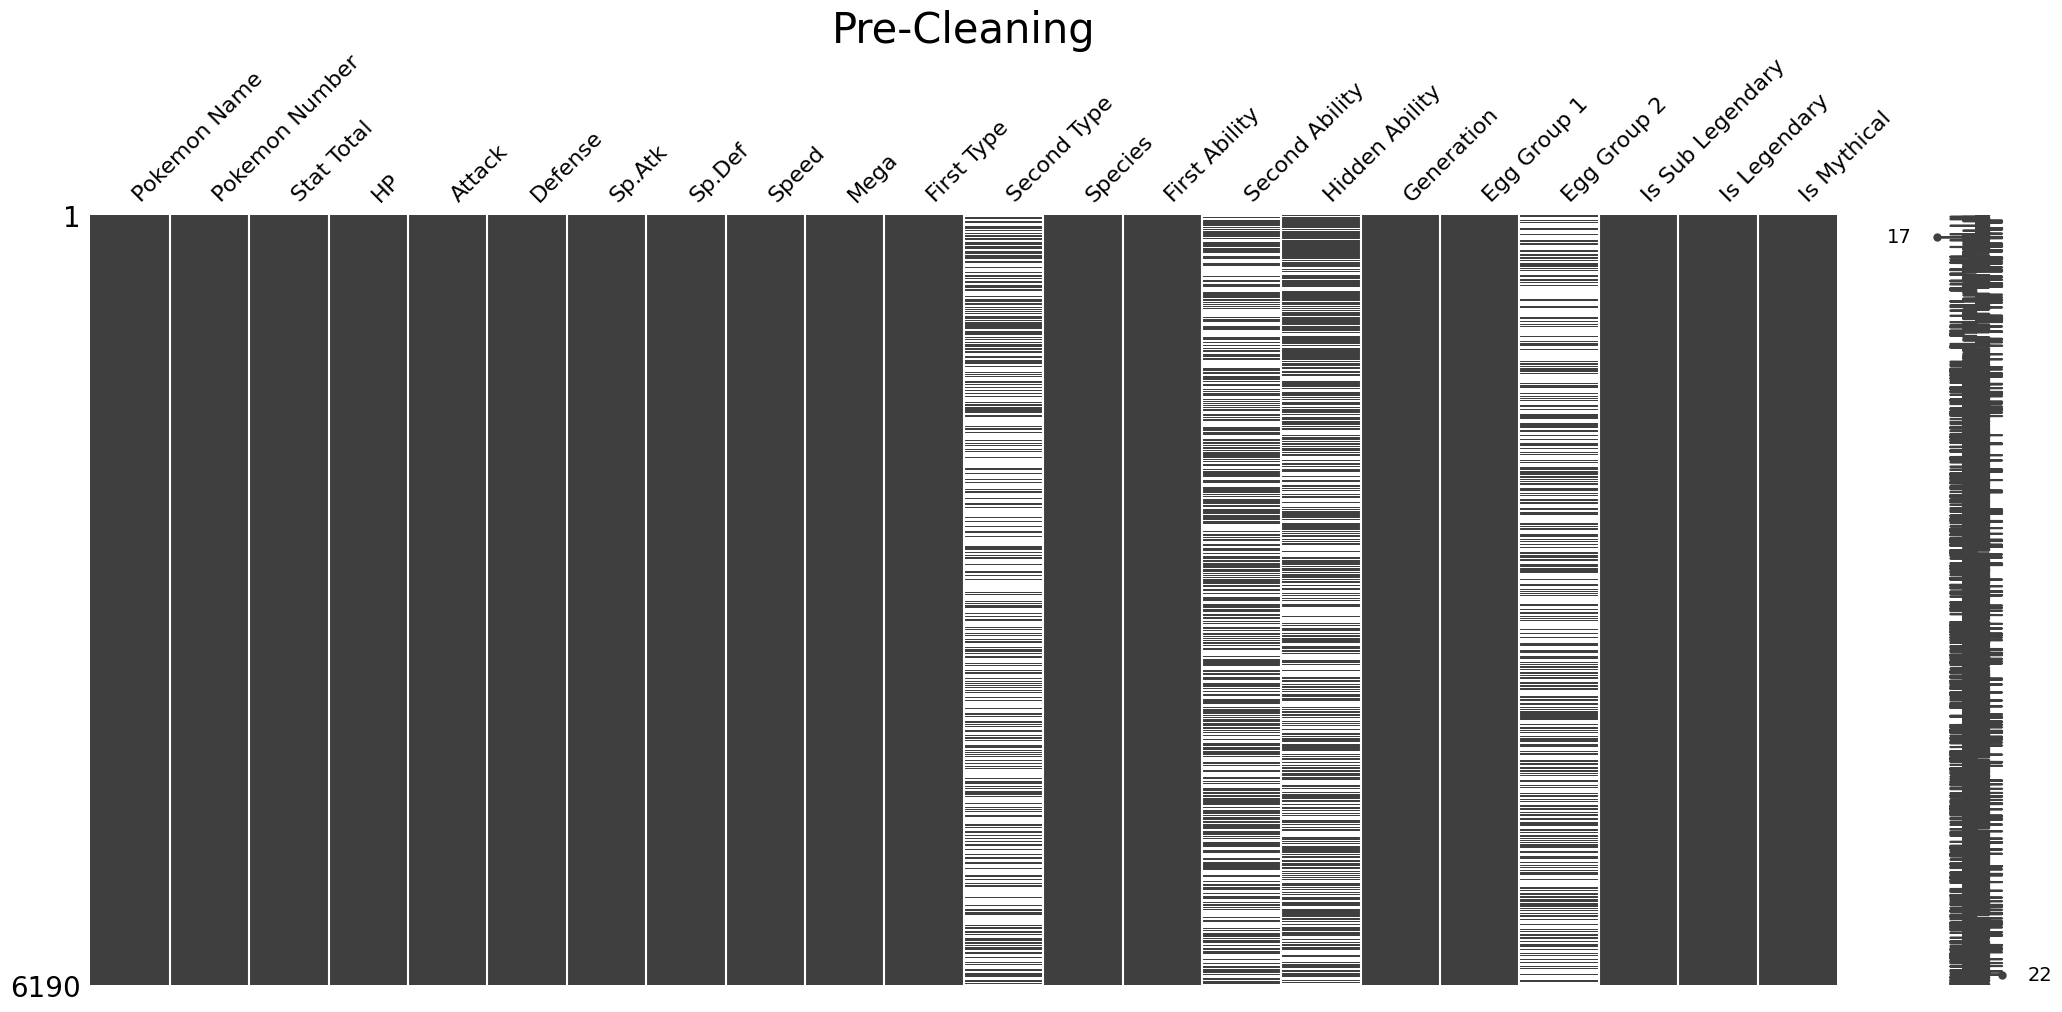

In [735]:
mn.matrix(df)
plt.title("Pre-Cleaning", fontsize=30)
plt.show()

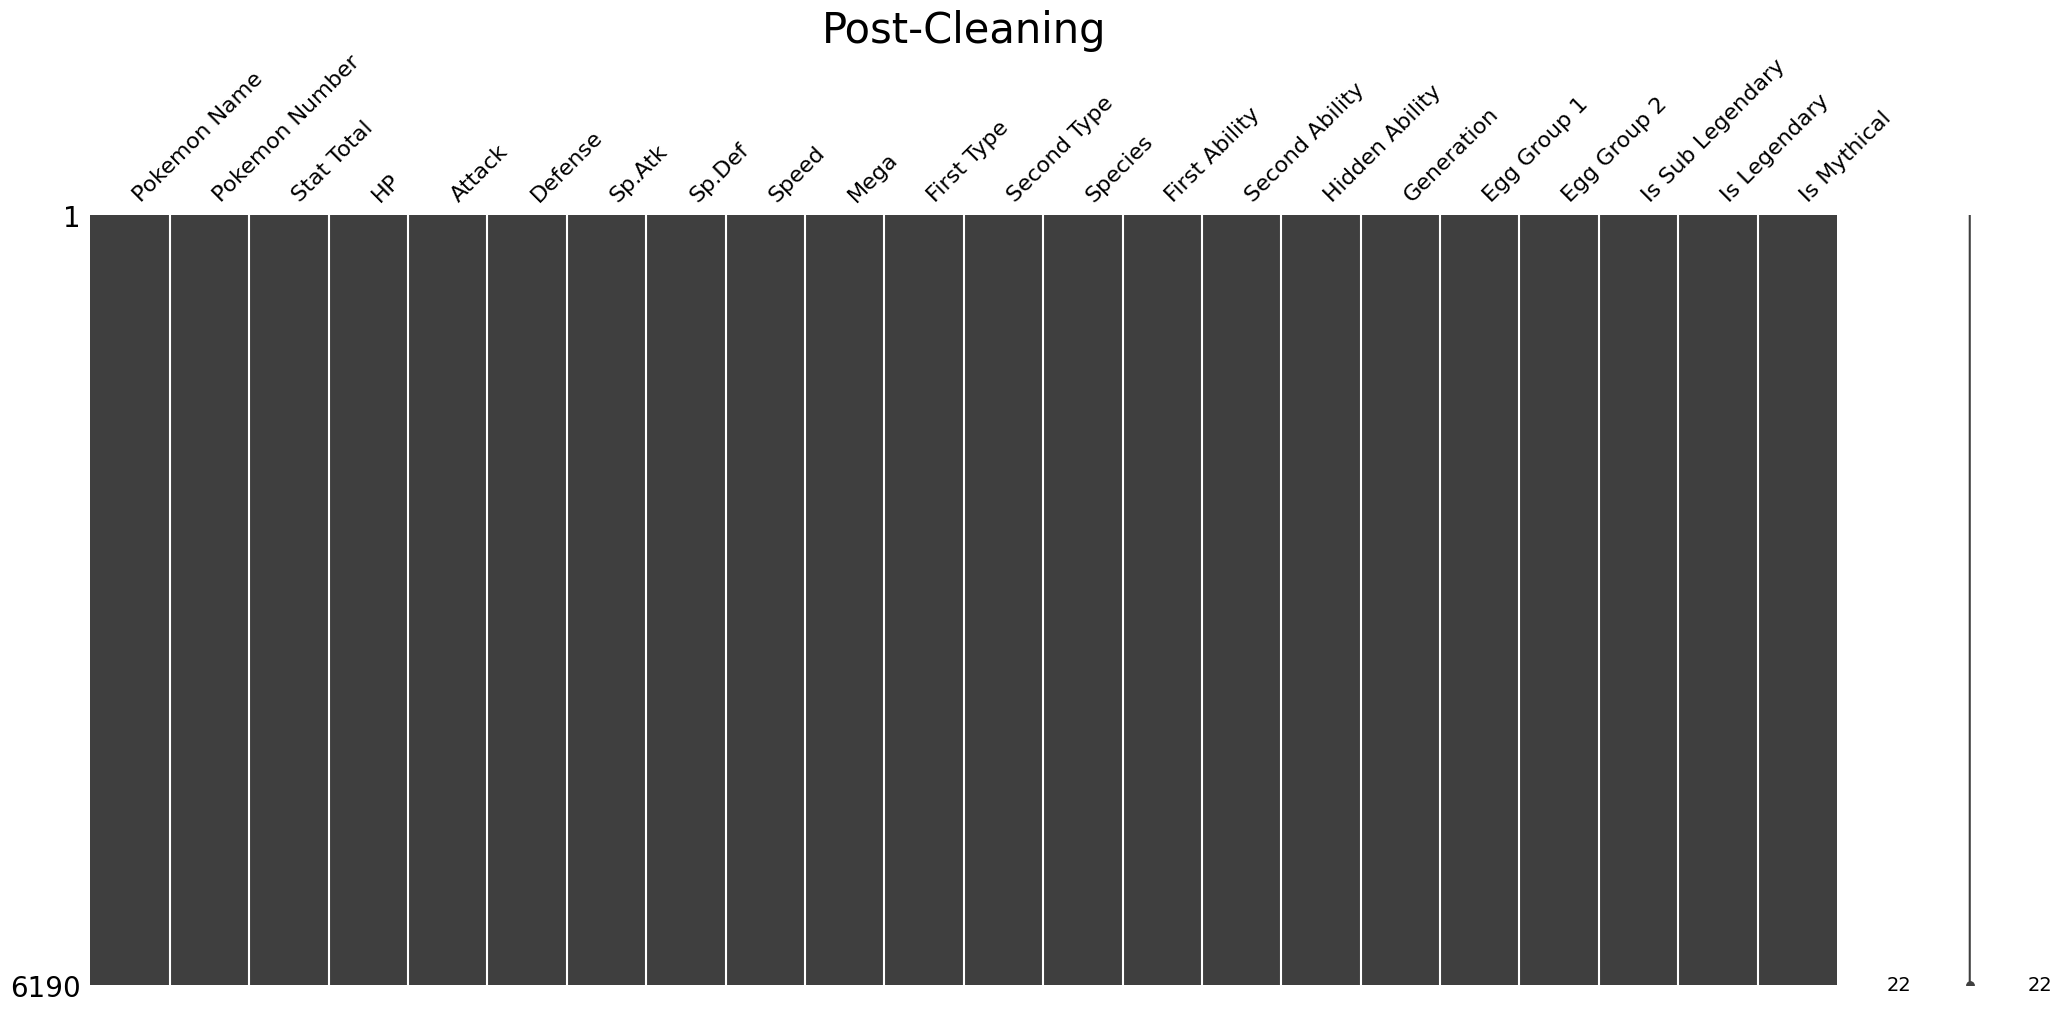

In [736]:
df.fillna('NA', inplace=True)
mn.matrix(df)
plt.title("Post-Cleaning", fontsize=30)
plt.show()

Now, we will encode the categorical features as integers, and scale any continuous data. We will also replace spaces with _

In [737]:
def replace_space(name):
    return name.replace(' ', '_')

# Apply this function to each column name
df.rename(columns=lambda x: replace_space(x), inplace=True)

print(df.head())

              Pokemon_Name  Pokemon_Number  Stat_Total  HP  Attack  Defense  \
0                Bulbasaur               1         318  45      49       49   
1                  Ivysaur               2         405  60      62       63   
2                 Venusaur               3         525  80      82       83   
3  Venusaur(Mega Venusaur)               3         625  80     100      123   
4               Charmander               4         309  39      52       43   

   Sp.Atk  Sp.Def  Speed   Mega  ...         Species First_Ability  \
0      65      65     45  False  ...    Seed Pokémon      Overgrow   
1      80      80     60  False  ...    Seed Pokémon      Overgrow   
2     100     100     80  False  ...    Seed Pokémon      Overgrow   
3     122     120     80   True  ...    Seed Pokémon     Thick Fat   
4      60      50     65  False  ...  Lizard Pokémon         Blaze   

  Second_Ability Hidden_Ability    Generation Egg_Group_1 Egg_Group_2  \
0             NA    Chlorophyll

In [738]:
df.head()

Pokemon_Name  Pokemon_Number  Stat_Total  HP  Attack  Defense  \
0                Bulbasaur               1         318  45      49       49   
1                  Ivysaur               2         405  60      62       63   
2                 Venusaur               3         525  80      82       83   
3  Venusaur(Mega Venusaur)               3         625  80     100      123   
4               Charmander               4         309  39      52       43   

   Sp.Atk  Sp.Def  Speed   Mega  ...         Species First_Ability  \
0      65      65     45  False  ...    Seed Pokémon      Overgrow   
1      80      80     60  False  ...    Seed Pokémon      Overgrow   
2     100     100     80  False  ...    Seed Pokémon      Overgrow   
3     122     120     80   True  ...    Seed Pokémon     Thick Fat   
4      60      50     65  False  ...  Lizard Pokémon         Blaze   

  Second_Ability Hidden_Ability    Generation Egg_Group_1 Egg_Group_2  \
0             NA    Chlorophyll  Generation 1       Grass     Monster   
1             NA    Chlorophyll  Generation 1       Grass     Monster   
2             NA    Chlorophyll  Generation 1       Grass     Monster   
3             NA             NA  Generation 6       Grass     Monster   
4             NA    Solar Power  Generation 1      Dragon     Monster   

  Is_Sub_Legendary Is_Legendary  Is_Mythical  
0            False        False        False  
1            False        False        False  
2            False        False        False  
3            False        False        False  
4            False        False        False  

[5 rows x 22 columns]

Dataset Description

In [835]:
print(df)

                 Pokemon_Name  Pokemon_Number  Stat_Total     HP  Attack  \
0                   Bulbasaur             1.0       318.0   45.0    49.0   
1                     Ivysaur             2.0       405.0   60.0    62.0   
2                    Venusaur             3.0       525.0   80.0    82.0   
3     Venusaur(Mega Venusaur)             3.0       625.0   80.0   100.0   
4                  Charmander             4.0       309.0   39.0    52.0   
...                       ...             ...         ...    ...     ...   
6185                      Ncl          6004.0       600.0  110.0    40.0   
6186                   Ituhym          6005.0       410.0  120.0    30.0   
6187                 Fxcwadoy          6006.0       670.0   80.0    40.0   
6188                      Ubu          6007.0       480.0   60.0   130.0   
6189                Hpigbtlqs          6008.0       380.0  110.0    40.0   

      Defense  Sp.Atk  Sp.Def  Speed   Mega  ...         Species  \
0        49.0    65

In [739]:
from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import StandardScaler

# replace weird strings inconsistency in the dataset, remove white space
if df["Is_Legendary"].dtype=='bool':
    df["Is_Legendary"].replace(to_replace=['True','False'],
                           value=['1','0'],
                           inplace=True)


    print(df["Is_Legendary"].value_counts())


    # remove white space


    # encode the label of target as an integer
    tmp = LabelEncoder()
    df["Is_Legendary"] = tmp.fit_transform(df["Is_Legendary"])


# ========================================================
# define variables that should be encoded as integers
categorical_headers = ['First_Type','Second_Type','Species',
                       'First_Ability','Second_Ability','Hidden_Ability','Egg_Group_1','Egg_Group_2']

# get unique values in each feature
for col in categorical_headers:
    print(f'{col} has {len(df[col].unique())} unique values.')

# ========================================================
# define variables that should be scaled or made discrete
numeric_headers = ['Pokemon_Number', 'Stat_Total', 'HP','Attack', 'Defense', 'Sp.Atk', 'Sp.Def', 'Speed']
df[numeric_headers] = df[numeric_headers].to_numpy().astype(float)


df.head()

Is_Legendary
False    5829
True      361
Name: count, dtype: int64
First_Type has 18 unique values.
Second_Type has 19 unique values.
Species has 3051 unique values.
First_Ability has 273 unique values.
Second_Ability has 273 unique values.
Hidden_Ability has 165 unique values.
Egg_Group_1 has 15 unique values.
Egg_Group_2 has 16 unique values.


Pokemon_Name  Pokemon_Number  Stat_Total    HP  Attack  Defense  \
0                Bulbasaur             1.0       318.0  45.0    49.0     49.0   
1                  Ivysaur             2.0       405.0  60.0    62.0     63.0   
2                 Venusaur             3.0       525.0  80.0    82.0     83.0   
3  Venusaur(Mega Venusaur)             3.0       625.0  80.0   100.0    123.0   
4               Charmander             4.0       309.0  39.0    52.0     43.0   

   Sp.Atk  Sp.Def  Speed   Mega  ...         Species First_Ability  \
0    65.0    65.0   45.0  False  ...    Seed Pokémon      Overgrow   
1    80.0    80.0   60.0  False  ...    Seed Pokémon      Overgrow   
2   100.0   100.0   80.0  False  ...    Seed Pokémon      Overgrow   
3   122.0   120.0   80.0   True  ...    Seed Pokémon     Thick Fat   
4    60.0    50.0   65.0  False  ...  Lizard Pokémon         Blaze   

  Second_Ability Hidden_Ability    Generation Egg_Group_1 Egg_Group_2  \
0             NA    Chlorophyll  Generation 1       Grass     Monster   
1             NA    Chlorophyll  Generation 1       Grass     Monster   
2             NA    Chlorophyll  Generation 1       Grass     Monster   
3             NA             NA  Generation 6       Grass     Monster   
4             NA    Solar Power  Generation 1      Dragon     Monster   

  Is_Sub_Legendary Is_Legendary  Is_Mythical  
0            False            0        False  
1            False            0        False  
2            False            0        False  
3            False            0        False  
4            False            0        False  

[5 rows x 22 columns]

Many Pokemon only have one type, egg group, or ability. These Pokemon are represented by the original data set as having a missing value for the second category, so we filled in the missing values with NA in order to keep this characteristic and protect them from being removed because they only have a single value for these categories.

# 2.1

*Identify groups of features in your data that should be combined into cross-product features. Provide a compelling justification for why these features should be crossed (or why some features should not be crossed).*

The groups of features in our data that we decided should be combined into cross-product features are First Type, Second Type, Egg Group 1, Egg Group 2, First Ability, and Second ABility to use the information to determine if a hypothetical new pokemon would be classified as a Legendary Pokemon. This is many legendary pokemon have unique combination of typings, or egg groups, or abilities, so crossing these features should reveal some correlation. We considered crossing Hidden Ability, but we realized that most legendary pokemon do not have hidden abilities, therefore it would be more computationally efficient to ignore crossing hidden abilities.

# 2.2
*Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.*

We will be using F1 score because it integrates precision and recall into a single metric to gain a better understanding of model performance. We don't want the algorithm to accidentally end up becoming too biased towards certain demographics or job types.

We had to implement a custom F1_score function in order for the code to work.

In [740]:
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# 2.3
*Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. Use the method to split your data that you argue for.*

We will divide the dataset into a training and testing data set along an 80/20 split. Because our data is not time sensitive, 80/20 is sufficient for our needs. We will use stratified 10-fold cross validation in order to maintain a balanced dataset for training and testing.

In [741]:
batch_size = 128
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
def create_dataset_from_dataframe(df_input):

    df = df_input.copy()
    labels = df['Is_Legendary']

    df = {key: value.values[:,np.newaxis] for key, value in df_input[categorical_headers+numeric_headers].items()}

    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))

    # now enable batching and prefetching
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)

    return ds

ds_train = create_dataset_from_dataframe(df_train)
ds_test = create_dataset_from_dataframe(df_test)

In [742]:
# here is an example of what the data looks like from this class
[(feat,label)] = ds_train.take(1)
print('The keys in the feature data are:')
print(feat.keys())
print('\nThe feature shape for Stat Total is:')
print('Shape:',feat['Stat_Total'].shape)
print('Max:',max(feat['Stat_Total']))
print('\nThe labels for this batch are:')
print(label) # print one batch of the labels

The keys in the feature data are:
dict_keys(['First_Type', 'Second_Type', 'Species', 'First_Ability', 'Second_Ability', 'Hidden_Ability', 'Egg_Group_1', 'Egg_Group_2', 'Pokemon_Number', 'Stat_Total', 'HP', 'Attack', 'Defense', 'Sp.Atk', 'Sp.Def', 'Speed'])

The feature shape for Stat Total is:
Shape: (128, 1)
Max: tf.Tensor([700.], shape=(1,), dtype=float64)

The labels for this batch are:
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(128,), dtype=int64)


In [743]:
print(ds_train)

<_PrefetchDataset element_spec=({'First_Type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Second_Type': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Species': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'First_Ability': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Second_Ability': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Hidden_Ability': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Egg_Group_1': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Egg_Group_2': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'Pokemon_Number': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Stat_Total': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'HP': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Attack': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Defense': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'Sp.Atk': TensorSpec(shape=(None, 1), d

In [744]:
skf = StratifiedKFold(n_splits=10, shuffle = True)
skf.get_n_splits(ds_train, ds_test)
print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=True)


# 3.0 Modeling
Create at least three combined wide and deep networks to classify your data using Keras (this total of "three" includes the model you will train in the next step of the rubric). Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations.

    Note: you can use the "history" return parameter that is part of Keras "fit" function to easily access this data.


Model 1 - Using first type and second type as our cross columns

In [745]:
def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?

    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output


    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col_name+'_embed')(x)

    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)

    return x

In [746]:
def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())

    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output

    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col_name+'_embed')(x)

    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)

    return x # return the tensor here

In [747]:
# Crossing columns together
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "First_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Species": FeatureSpace.string_categorical(num_oov_indices=1),
        "First_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Hidden_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_1": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_2": FeatureSpace.string_categorical(num_oov_indices=1),


        "Pokemon_Number": FeatureSpace.float_normalized(),
        "Stat_Total": FeatureSpace.float_normalized(),
        "HP": FeatureSpace.float_normalized(),
        "Attack": FeatureSpace.float_normalized(),
        "Defense": FeatureSpace.float_normalized(),
        "Sp.Atk": FeatureSpace.float_normalized(),
        "Sp.Def": FeatureSpace.float_normalized(),
        "Speed": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dim
    crosses=[
        FeatureSpace.cross(
            feature_names=('First_Type','Second_Type'), # dims: 7 x 14 =
            crossing_dim=18*19),
        #Ability cross takes too much time
        #FeatureSpace.cross(
         #   feature_names=('First_Ability','Second_Ability','Hidden_Ability'), # 7 x 2 x 5
          #  crossing_dim=273*270*165),
        #FeatureSpace.cross(
         #   feature_names=('Egg_Group_1','Egg_Group_2'), # 14 x 16
          #  crossing_dim=15*12),
    ],
    output_mode="concat",
)

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [748]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():

    x = setup_embedding_from_crossing(feature_space, col)

    # save these outputs in list to concatenate later
    crossed_outputs.append(x)


# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for idx,col in enumerate(numeric_headers):
    x = feature_space.preprocessors[col].output
    x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:

    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)

    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)


# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)

# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

training_model_1 = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model_1.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[f1_score]
)

training_model_1.summary()



Model: "model_66"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 First_Type (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Second_Type (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Species (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 First_Ability (InputLayer)  [(None, 1)]                  0         []                            
                                                                                           

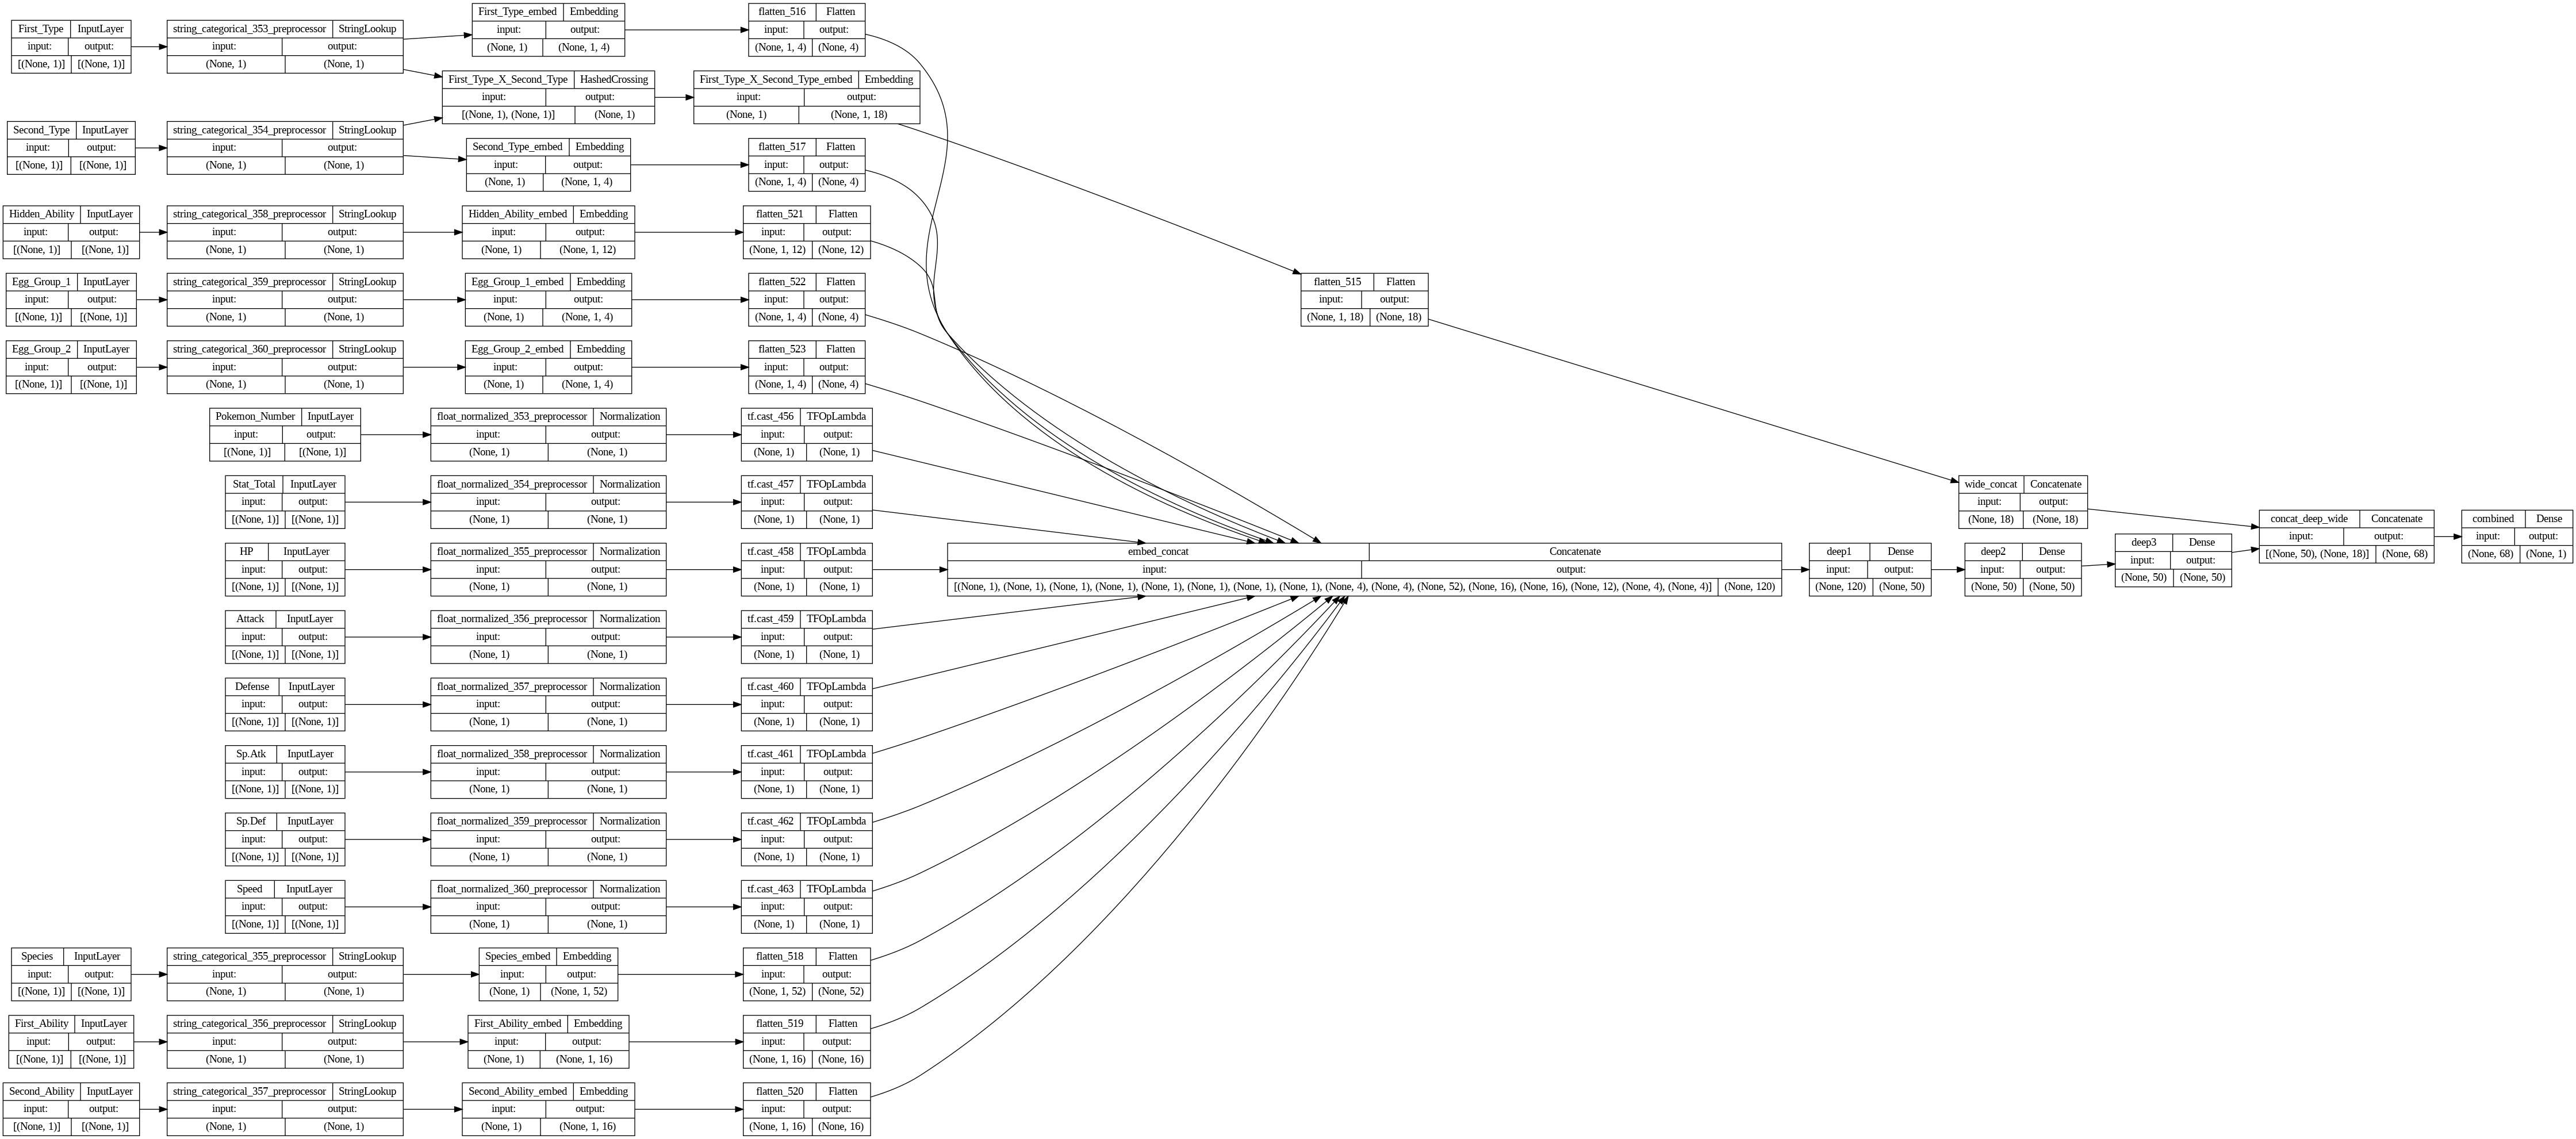

In [749]:
plot_model(
    training_model_1, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [750]:

training_model_1.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[f1_score]
)

In [751]:
history_1 = training_model_1.fit(
    ds_train, epochs=10, validation_data=ds_test, verbose=1
)

Epoch 1/10
39/39 [==============================] - 3s 16ms/step - loss: 0.4619 - f1_score: 0.0219 - val_loss: 0.2335 - val_f1_score: 0.0000e+00
Epoch 2/10
39/39 [==============================] - 0s 6ms/step - loss: 0.1383 - f1_score: 0.0000e+00 - val_loss: 0.1065 - val_f1_score: 0.0000e+00
Epoch 3/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0654 - f1_score: 0.2236 - val_loss: 0.0566 - val_f1_score: 0.7493
Epoch 4/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0304 - f1_score: 0.9528 - val_loss: 0.0212 - val_f1_score: 0.9866
Epoch 5/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0091 - f1_score: 0.9940 - val_loss: 0.0108 - val_f1_score: 0.9842
Epoch 6/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0037 - f1_score: 0.9940 - val_loss: 0.0101 - val_f1_score: 0.9842
Epoch 7/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0020 - f1_score: 0.9957 - val_loss: 0.0115 - val_f1_score: 0.9776
Epoch 8

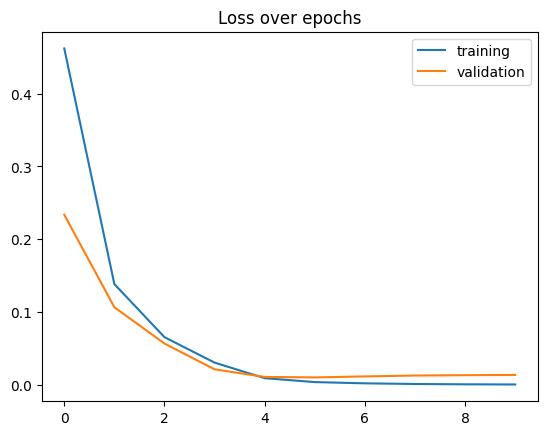

In [752]:
plt.plot(history_1.history['loss'],label='training')
plt.plot(history_1.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss over epochs')
plt.show()

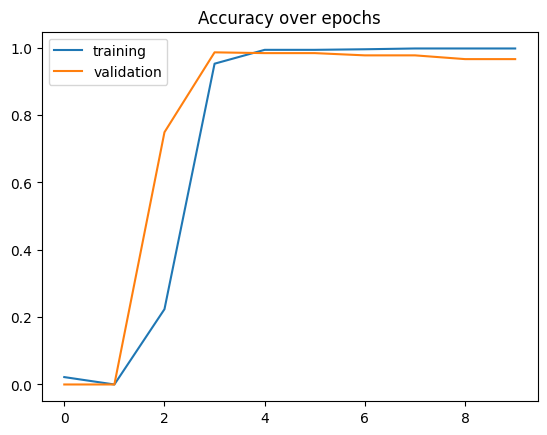

In [753]:
plt.plot(history_1.history['f1_score'],label='training')
plt.plot(history_1.history['val_f1_score'],label='validation')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

In [754]:
average_train_f1_model_1 = sum(history_1.history['f1_score']) / len(history_1.history['f1_score'])
average_val_f1__model_1 = sum(history_1.history['val_f1_score']) / len(history_1.history['val_f1_score'])

print(f"Average Training F1 Score: {average_train_f1_model_1}")
print(f"Average Validation F1 Score: {average_val_f1__model_1}")

Average Training F1 Score: 0.7176166886463762
Average Validation F1 Score: 0.7592328429222107


Model 2

Only using egg group 1 and egg group 2 as our cross columns

In [755]:
# Crossing columns together
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "First_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Species": FeatureSpace.string_categorical(num_oov_indices=1),
        "First_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Hidden_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_1": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_2": FeatureSpace.string_categorical(num_oov_indices=1),


        "Pokemon_Number": FeatureSpace.float_normalized(),
        "Stat_Total": FeatureSpace.float_normalized(),
        "HP": FeatureSpace.float_normalized(),
        "Attack": FeatureSpace.float_normalized(),
        "Defense": FeatureSpace.float_normalized(),
        "Sp.Atk": FeatureSpace.float_normalized(),
        "Sp.Def": FeatureSpace.float_normalized(),
        "Speed": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dim
    crosses=[
        #FeatureSpace.cross(
         #   feature_names=('First_Type','Second_Type'), # dims: 7 x 14 =
          #  crossing_dim=18*19),
        #Ability cross takes too much time
        #FeatureSpace.cross(
         #   feature_names=('First_Ability','Second_Ability','Hidden_Ability'), # 7 x 2 x 5
          #  crossing_dim=273*270*165),
        FeatureSpace.cross(
            feature_names=('Egg_Group_1','Egg_Group_2'), # 14 x 16
            crossing_dim=15*16),
    ],
    output_mode="concat",
)

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [756]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():

    x = setup_embedding_from_crossing(feature_space, col)

    # save these outputs in list to concatenate later
    crossed_outputs.append(x)


# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for idx,col in enumerate(numeric_headers):
    x = feature_space.preprocessors[col].output
    x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:

    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)

    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)


# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)

# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

training_model_2 = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model_2.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[f1_score]
)

training_model_2.summary()



Model: "model_67"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 First_Type (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Second_Type (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Species (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 First_Ability (InputLayer)  [(None, 1)]                  0         []                            
                                                                                           

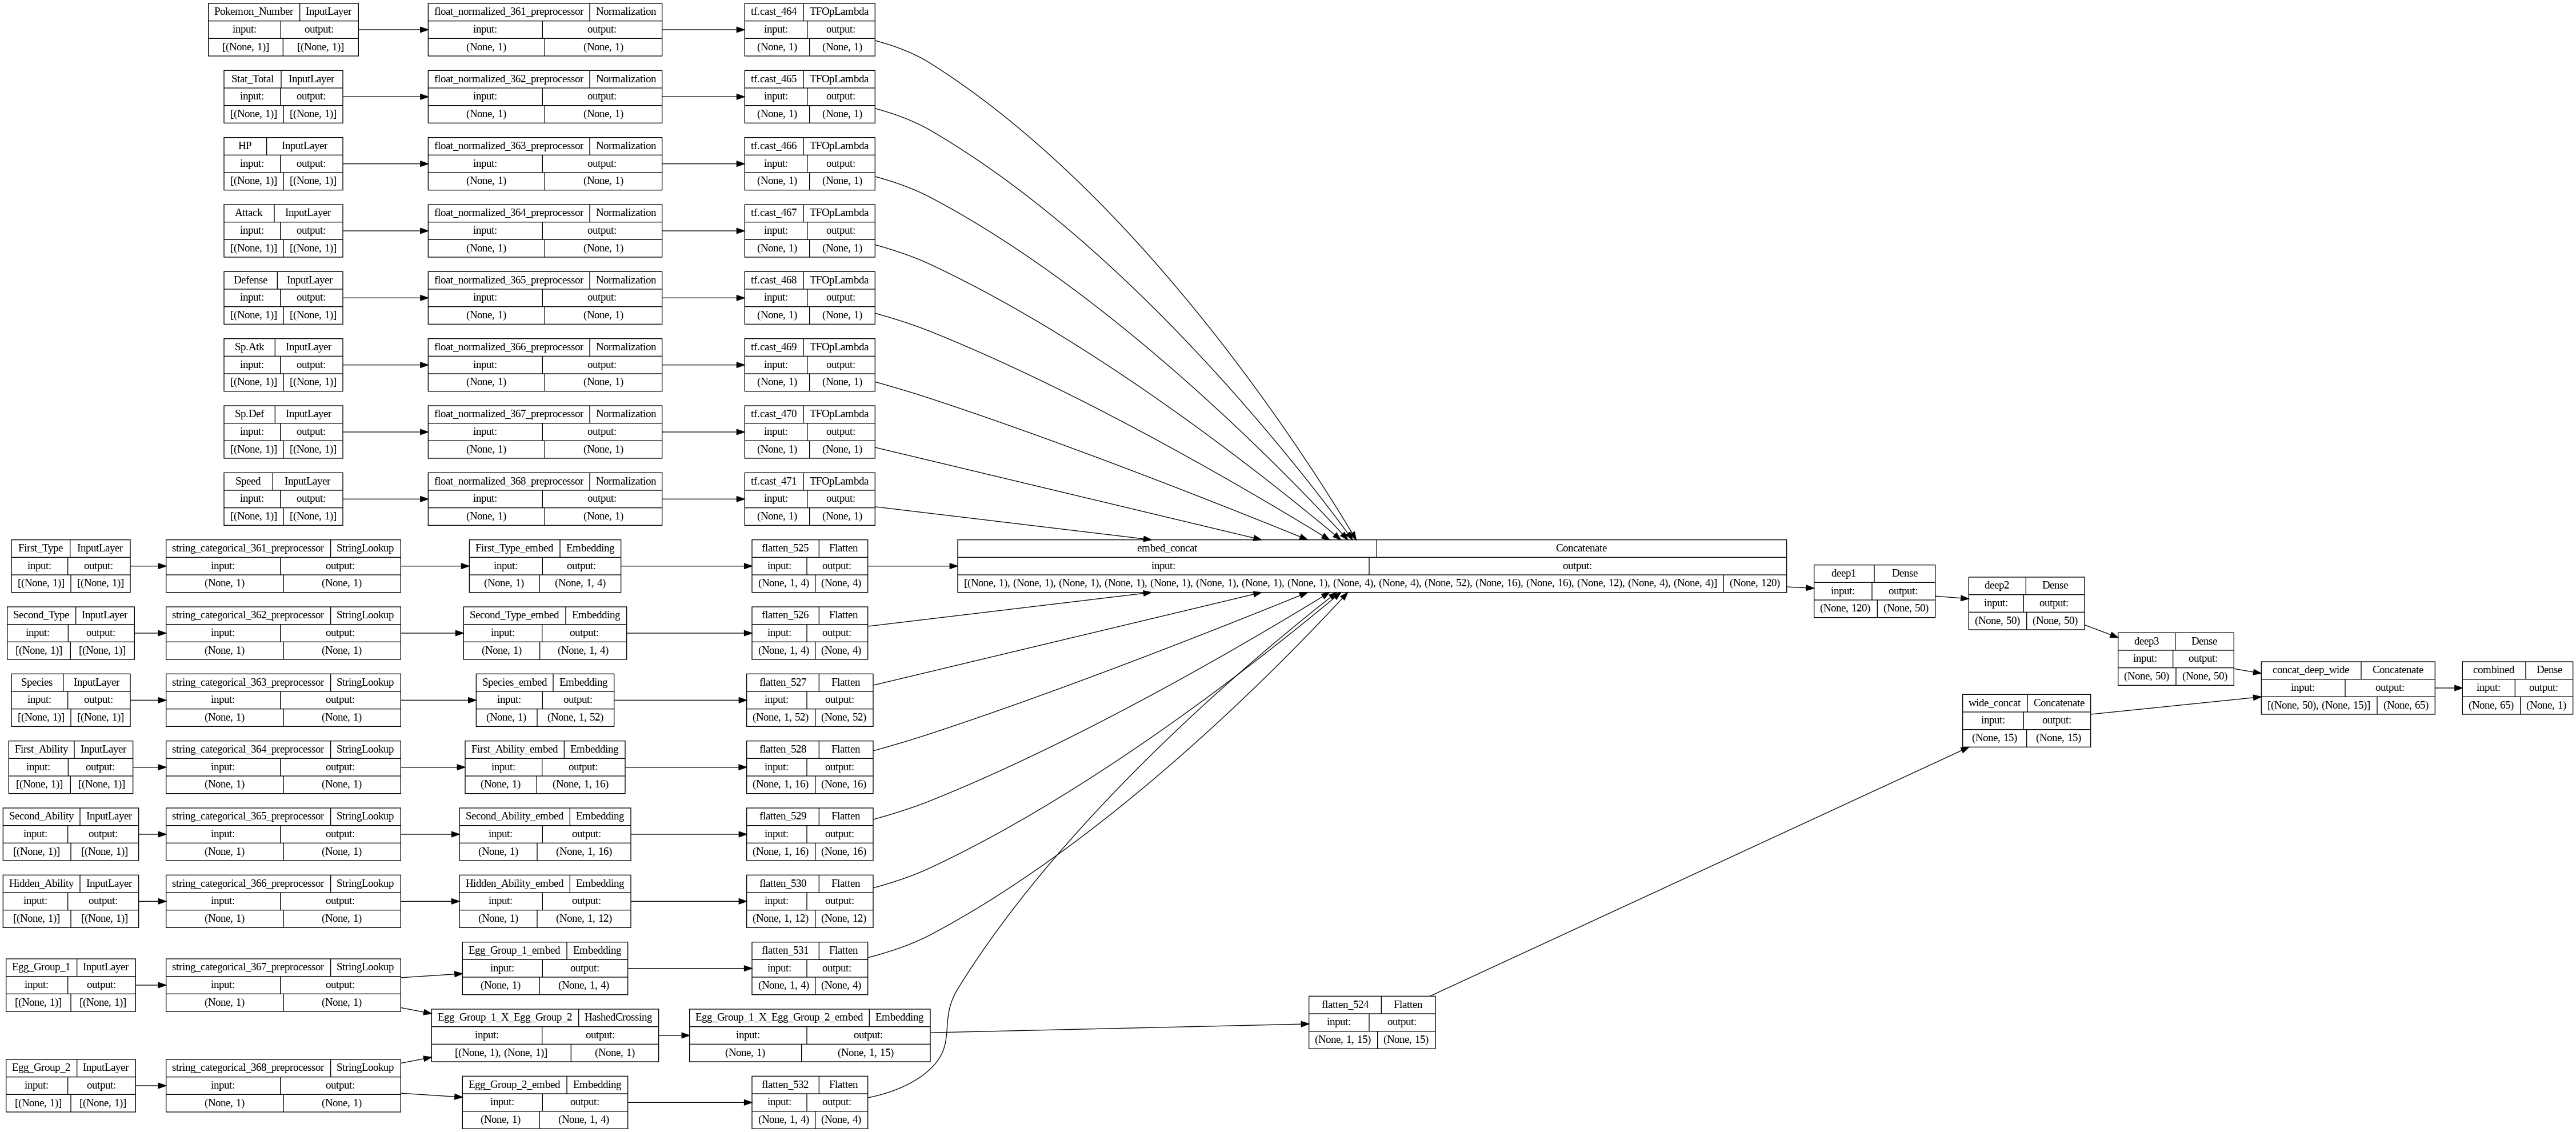

In [757]:
plot_model(
    training_model_2, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [758]:
# train using the already processed features
history_2 = training_model_2.fit(
    ds_train, epochs=10, validation_data=ds_test, verbose=1
)

Epoch 1/10
39/39 [==============================] - 4s 17ms/step - loss: 0.4009 - f1_score: 0.0144 - val_loss: 0.1977 - val_f1_score: 0.0000e+00
Epoch 2/10
39/39 [==============================] - 0s 7ms/step - loss: 0.1185 - f1_score: 0.0000e+00 - val_loss: 0.0905 - val_f1_score: 0.0000e+00
Epoch 3/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0546 - f1_score: 0.6572 - val_loss: 0.0443 - val_f1_score: 0.9515
Epoch 4/10
39/39 [==============================] - 0s 7ms/step - loss: 0.0249 - f1_score: 0.9813 - val_loss: 0.0201 - val_f1_score: 0.9875
Epoch 5/10
39/39 [==============================] - 0s 6ms/step - loss: 0.0095 - f1_score: 0.9940 - val_loss: 0.0121 - val_f1_score: 0.9842
Epoch 6/10
39/39 [==============================] - 0s 7ms/step - loss: 0.0042 - f1_score: 0.9957 - val_loss: 0.0119 - val_f1_score: 0.9776
Epoch 7/10
39/39 [==============================] - 0s 7ms/step - loss: 0.0023 - f1_score: 0.9957 - val_loss: 0.0141 - val_f1_score: 0.9776
Epoch 8

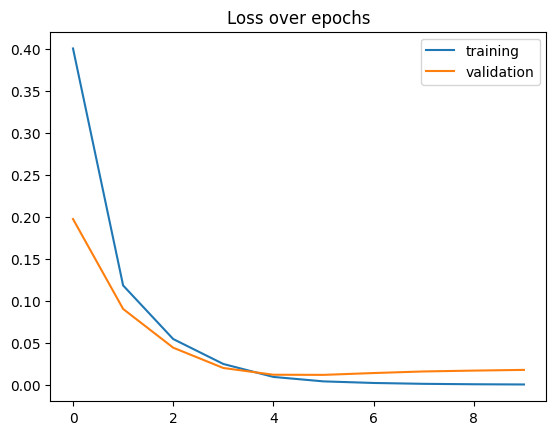

In [759]:
plt.plot(history_2.history['loss'],label='training')
plt.plot(history_2.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss over epochs')
plt.show()

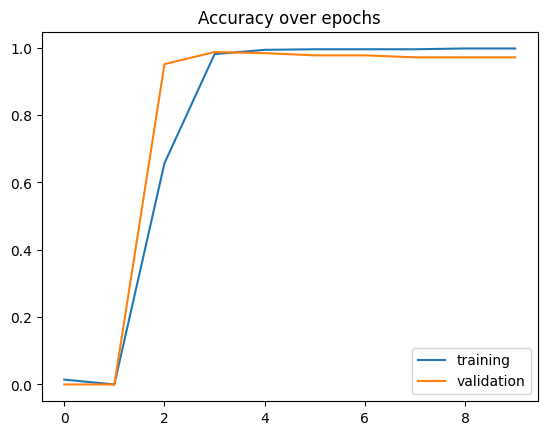

In [760]:
plt.plot(history_2.history['f1_score'],label='training')
plt.plot(history_2.history['val_f1_score'],label='validation')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

In [761]:
average_train_f1_model_2 = sum(history_2.history['f1_score']) / len(history_2.history['f1_score'])
average_val_f1__model_2 = sum(history_2.history['val_f1_score']) / len(history_2.history['val_f1_score'])

print(f"Average Training F1 Score: {average_train_f1_model_2}")
print(f"Average Validation F1 Score: {average_val_f1__model_2}")

Average Training F1 Score: 0.7630076579749584
Average Validation F1 Score: 0.7793440163135529


Model 3

Using First and Second Ability as our cross columns

In [762]:
# Crossing columns together
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "First_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Species": FeatureSpace.string_categorical(num_oov_indices=1),
        "First_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Hidden_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_1": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_2": FeatureSpace.string_categorical(num_oov_indices=1),


        "Pokemon_Number": FeatureSpace.float_normalized(),
        "Stat_Total": FeatureSpace.float_normalized(),
        "HP": FeatureSpace.float_normalized(),
        "Attack": FeatureSpace.float_normalized(),
        "Defense": FeatureSpace.float_normalized(),
        "Sp.Atk": FeatureSpace.float_normalized(),
        "Sp.Def": FeatureSpace.float_normalized(),
        "Speed": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dim
    crosses=[

        FeatureSpace.cross(
            feature_names=('First_Ability','Second_Ability'),
            crossing_dim=273*273),

    ],
    output_mode="concat",
)

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [763]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():

    x = setup_embedding_from_crossing(feature_space, col)

    # save these outputs in list to concatenate later
    crossed_outputs.append(x)


# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for idx,col in enumerate(numeric_headers):
    x = feature_space.preprocessors[col].output
    x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# for each categorical variable
for col in categorical_headers:

    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)

    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)


# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)

# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

training_model_3 = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model_3.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[f1_score]
)

training_model_3.summary()



Model: "model_68"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 First_Type (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Second_Type (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Species (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 First_Ability (InputLayer)  [(None, 1)]                  0         []                            
                                                                                           

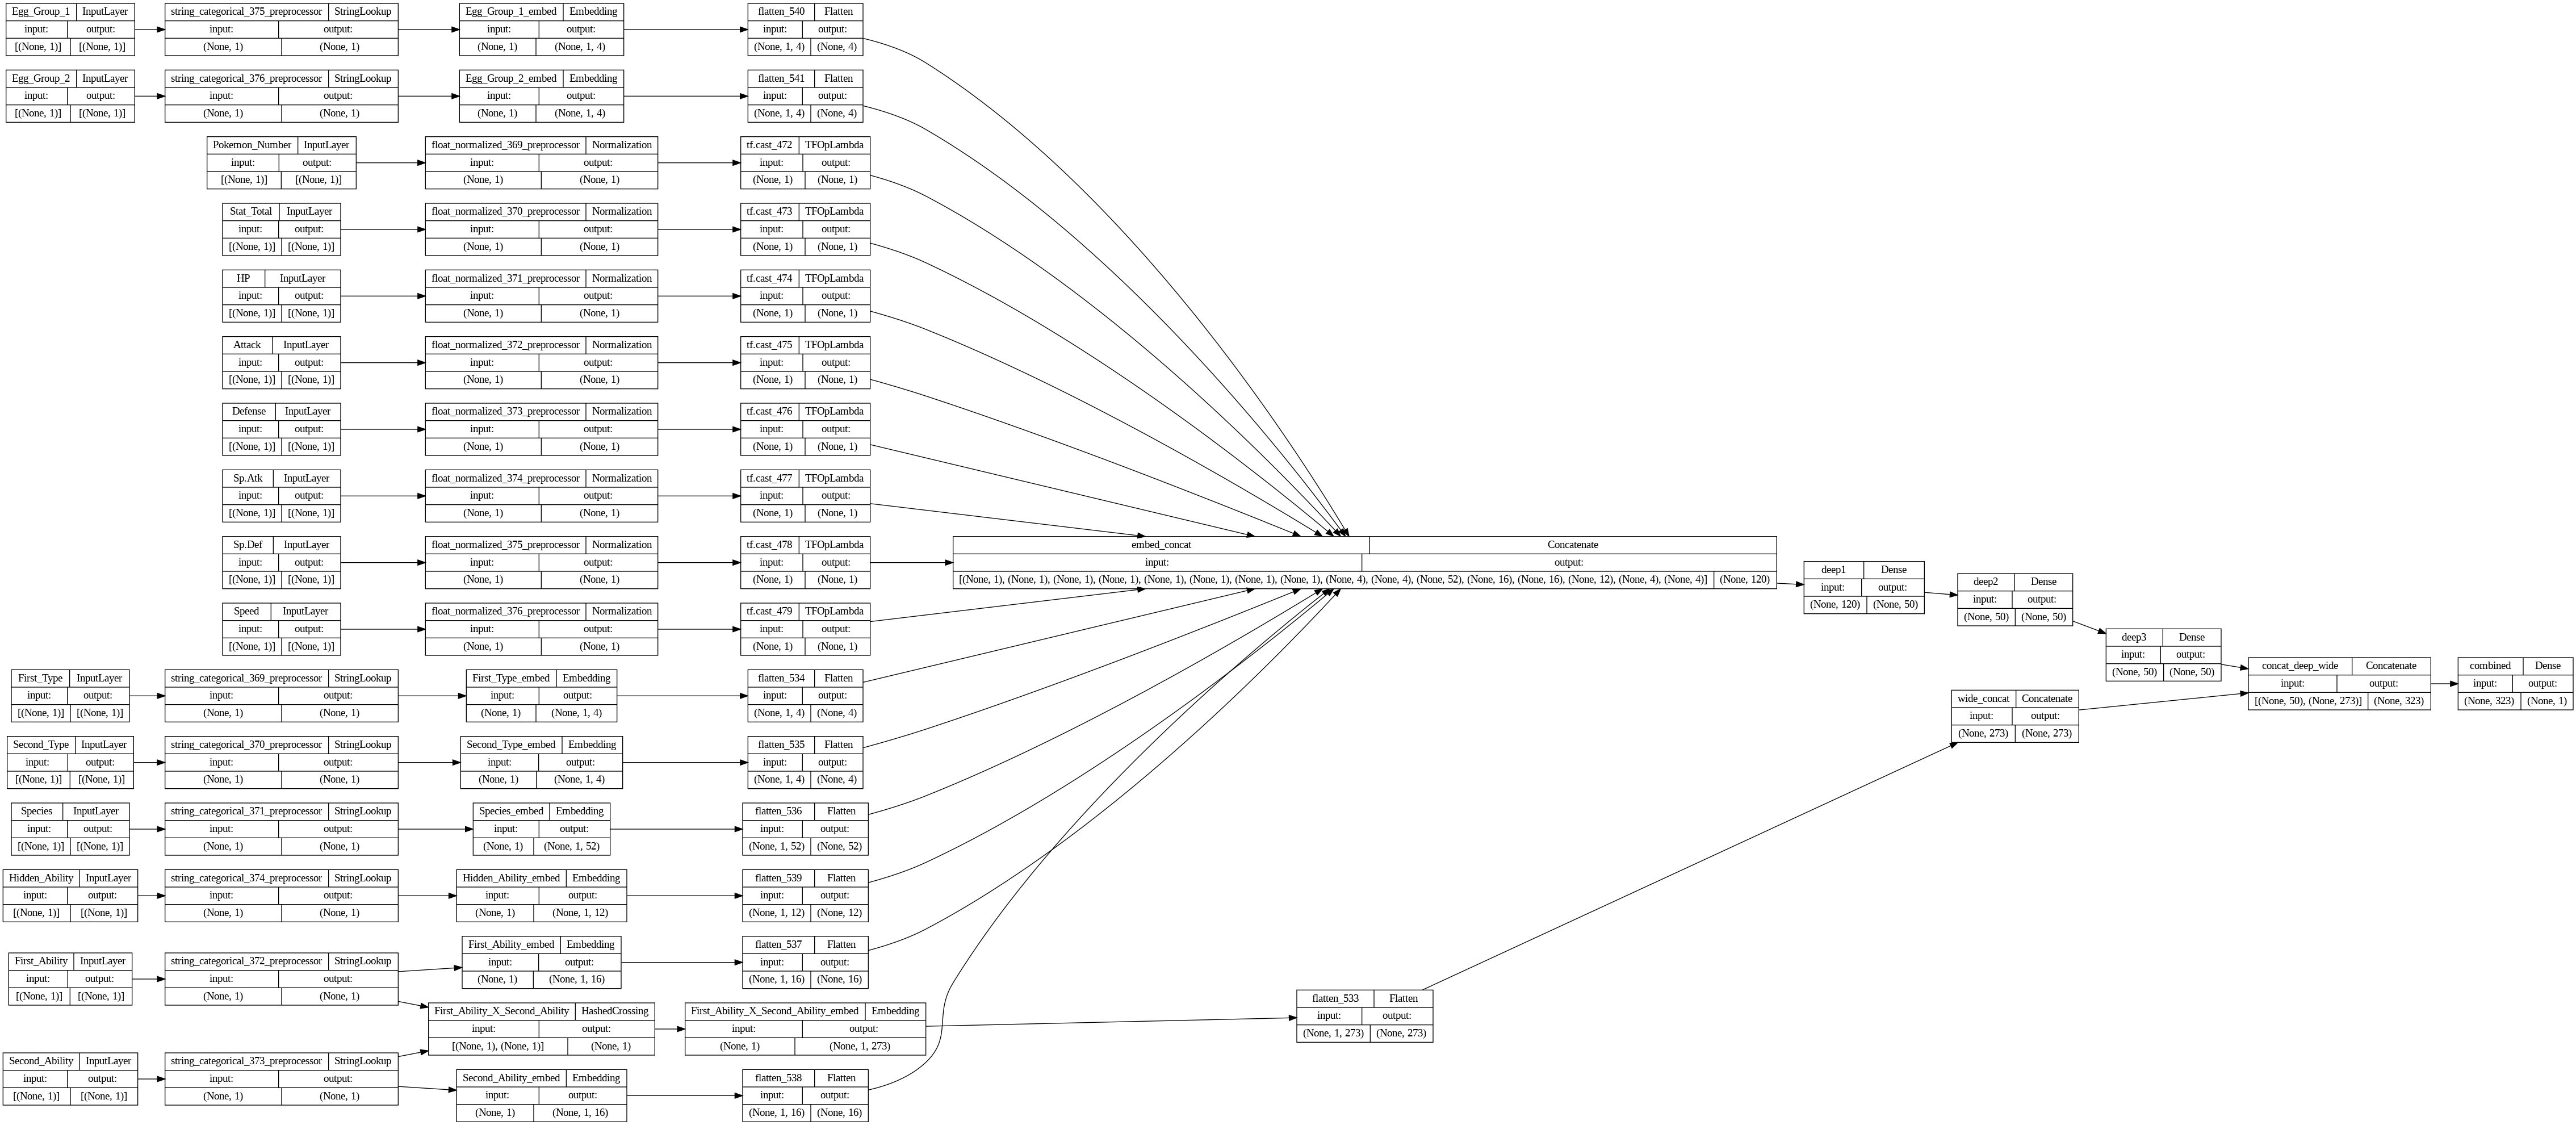

In [764]:
plot_model(
    training_model_3, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [765]:
history_3 = training_model_3.fit(
    ds_train, epochs=10, validation_data=ds_test, verbose=1
)

Epoch 1/10
39/39 [==============================] - 14s 293ms/step - loss: 0.4238 - f1_score: 0.0026 - val_loss: 0.2064 - val_f1_score: 0.0000e+00
Epoch 2/10
39/39 [==============================] - 11s 282ms/step - loss: 0.1137 - f1_score: 0.0587 - val_loss: 0.0897 - val_f1_score: 0.1647
Epoch 3/10
39/39 [==============================] - 11s 280ms/step - loss: 0.0502 - f1_score: 0.7726 - val_loss: 0.0525 - val_f1_score: 0.6625
Epoch 4/10
39/39 [==============================] - 11s 278ms/step - loss: 0.0277 - f1_score: 0.9836 - val_loss: 0.0380 - val_f1_score: 0.8086
Epoch 5/10
39/39 [==============================] - 11s 279ms/step - loss: 0.0171 - f1_score: 0.9957 - val_loss: 0.0310 - val_f1_score: 0.8705
Epoch 6/10
39/39 [==============================] - 11s 280ms/step - loss: 0.0107 - f1_score: 0.9957 - val_loss: 0.0268 - val_f1_score: 0.9083
Epoch 7/10
39/39 [==============================] - 11s 279ms/step - loss: 0.0065 - f1_score: 0.9957 - val_loss: 0.0234 - val_f1_score: 0.

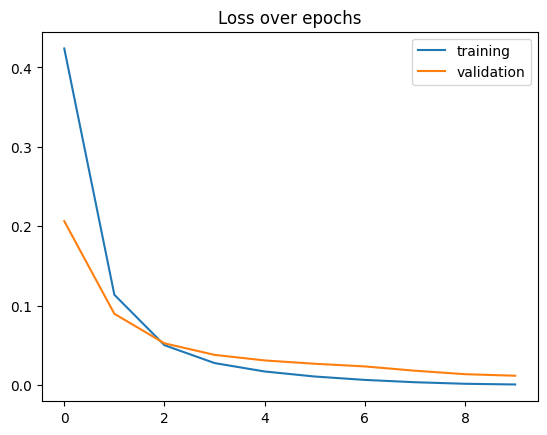

In [766]:
plt.plot(history_3.history['loss'],label='training')
plt.plot(history_3.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss over epochs')
plt.show()

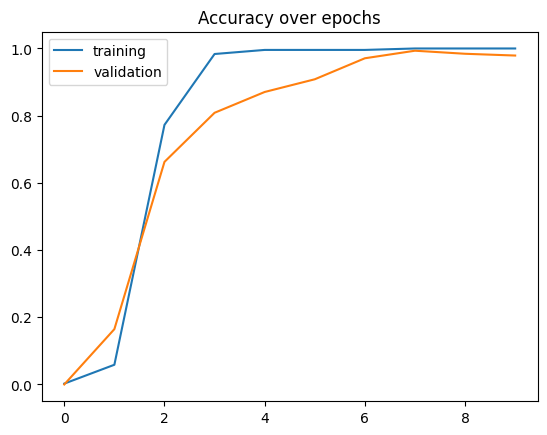

In [767]:
plt.plot(history_3.history['f1_score'],label='training')
plt.plot(history_3.history['val_f1_score'],label='validation')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

In [768]:
average_train_f1_model_3 = sum(history_3.history['f1_score']) / len(history_3.history['f1_score'])
average_val_f1__model_3 = sum(history_3.history['val_f1_score']) / len(history_3.history['val_f1_score'])

print(f"Average Training F1 Score: {average_train_f1_model_3}")
print(f"Average Validation F1 Score: {average_val_f1__model_3}")

Average Training F1 Score: 0.7804494268260896
Average Validation F1 Score: 0.73420519977808


In [769]:
average_train_f1_model_1 = sum(history_1.history['f1_score']) / len(history_1.history['f1_score'])
average_val_f1__model_1 = sum(history_1.history['val_f1_score']) / len(history_1.history['val_f1_score'])

print(f"Average Training F1 Score Model 1: {average_train_f1_model_1}")
print(f"Average Validation F1 Score Model 1: {average_val_f1__model_1}")

average_train_f1_model_2 = sum(history_2.history['f1_score']) / len(history_2.history['f1_score'])
average_val_f1__model_2 = sum(history_2.history['val_f1_score']) / len(history_2.history['val_f1_score'])

print(f"Average Training F1 Score Model 2: {average_train_f1_model_2}")
print(f"Average Validation F1 Score Model 2: {average_val_f1__model_2}")

average_train_f1_model_3 = sum(history_3.history['f1_score']) / len(history_3.history['f1_score'])
average_val_f1__model_3 = sum(history_3.history['val_f1_score']) / len(history_3.history['val_f1_score'])

print(f"Average Training F1 Score Model 3: {average_train_f1_model_3}")
print(f"Average Validation F1 Score Model 3: {average_val_f1__model_3}")

Average Training F1 Score Model 1: 0.7176166886463762
Average Validation F1 Score Model 1: 0.7592328429222107
Average Training F1 Score Model 2: 0.7630076579749584
Average Validation F1 Score Model 2: 0.7793440163135529
Average Training F1 Score Model 3: 0.7804494268260896
Average Validation F1 Score Model 3: 0.73420519977808


As shown in the average training and validation score, Model 2 performs the best on average out of all three models. Model 3 has the highes training score of 0.78, but the lowest validation score of 0.73. Model 2 has the second highest training f1 score of 0.76, which is only slightly less than Model 3, but Model 2 has the best validation score of 0.779 compared to 0.75 for Model 1 and 0.73 for Model 3. Therefore, we can conclude that Model 2 is the best model out of all three.

# 3.1
 Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two models (this "two" includes the wide and deep model trained from the previous step). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to answer: What model with what number of layers performs superiorly? Use proper statistical methods to compare the performance of different models.

 We will be using the feature space created in Model 2 from the previous step, which is just using egg group 1 and egg group 2 as our cross columns

Model 1: Only 1 Layer in Deep Network instead of 3

In [770]:
# Crossing columns together
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "First_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Species": FeatureSpace.string_categorical(num_oov_indices=1),
        "First_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Hidden_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_1": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_2": FeatureSpace.string_categorical(num_oov_indices=1),


        "Pokemon_Number": FeatureSpace.float_normalized(),
        "Stat_Total": FeatureSpace.float_normalized(),
        "HP": FeatureSpace.float_normalized(),
        "Attack": FeatureSpace.float_normalized(),
        "Defense": FeatureSpace.float_normalized(),
        "Sp.Atk": FeatureSpace.float_normalized(),
        "Sp.Def": FeatureSpace.float_normalized(),
        "Speed": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dim
    crosses=[
        #FeatureSpace.cross(
         #   feature_names=('First_Type','Second_Type'), # dims: 7 x 14 =
          #  crossing_dim=18*19),
        #Ability cross takes too much time
        #FeatureSpace.cross(
         #   feature_names=('First_Ability','Second_Ability','Hidden_Ability'), # 7 x 2 x 5
          #  crossing_dim=273*270*165),
        FeatureSpace.cross(
            feature_names=('Egg_Group_1','Egg_Group_2'), # 14 x 16
            crossing_dim=15*16),
    ],
    output_mode="concat",
)

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [771]:
# Create and compile the model
def create_model(feature_space, numeric_headers, categorical_headers):
    dict_inputs = feature_space.get_inputs()  # need to use unprocessed features here to gain access to each output

    # Wide branch with embedded cross features
    crossed_outputs = [setup_embedding_from_crossing(feature_space, col) for col in feature_space.crossers.keys()]
    wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

    # Deep branch with embeddings for categorical variables and raw inputs for numeric variables
    deep_inputs = [tf.cast(feature_space.preprocessors[col].output, float) for col in numeric_headers] + \
                  [setup_embedding_from_categorical(feature_space, col) for col in categorical_headers]
    deep_branch = Concatenate(name='embed_concat')(deep_inputs)
    deep_branch = Dense(units=50, activation='relu', name='deep_layer')(deep_branch)  # Simplified to one layer

    # Combine deep and wide branches
    final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
    final_branch = Dense(units=1, activation='sigmoid', name='combined')(final_branch)

    # Define the model
    model_1 = keras.Model(inputs=dict_inputs, outputs=final_branch)
    model_1.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[f1_score]
        )

    return model_1

model_1 = create_model(feature_space, numeric_headers, categorical_headers)
model_1.summary()

# Example training call
history_shallow = model_1.fit(ds_train, epochs=10, validation_data=ds_test, verbose=1)

# Calculating the average F1 score across all epochs for both training and validation
average_train_f1_shallow = sum(history_shallow.history['f1_score']) / len(history_shallow.history['f1_score'])
average_val_f1_shallow = sum(history_shallow.history['val_f1_score']) / len(history_shallow.history['val_f1_score'])

print(f"Average Training F1 Score: {average_train_f1_shallow}")
print(f"Average Validation F1 Score: {average_val_f1_shallow}")



Model: "model_69"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 First_Type (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Second_Type (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Species (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 First_Ability (InputLayer)  [(None, 1)]                  0         []                            
                                                                                           

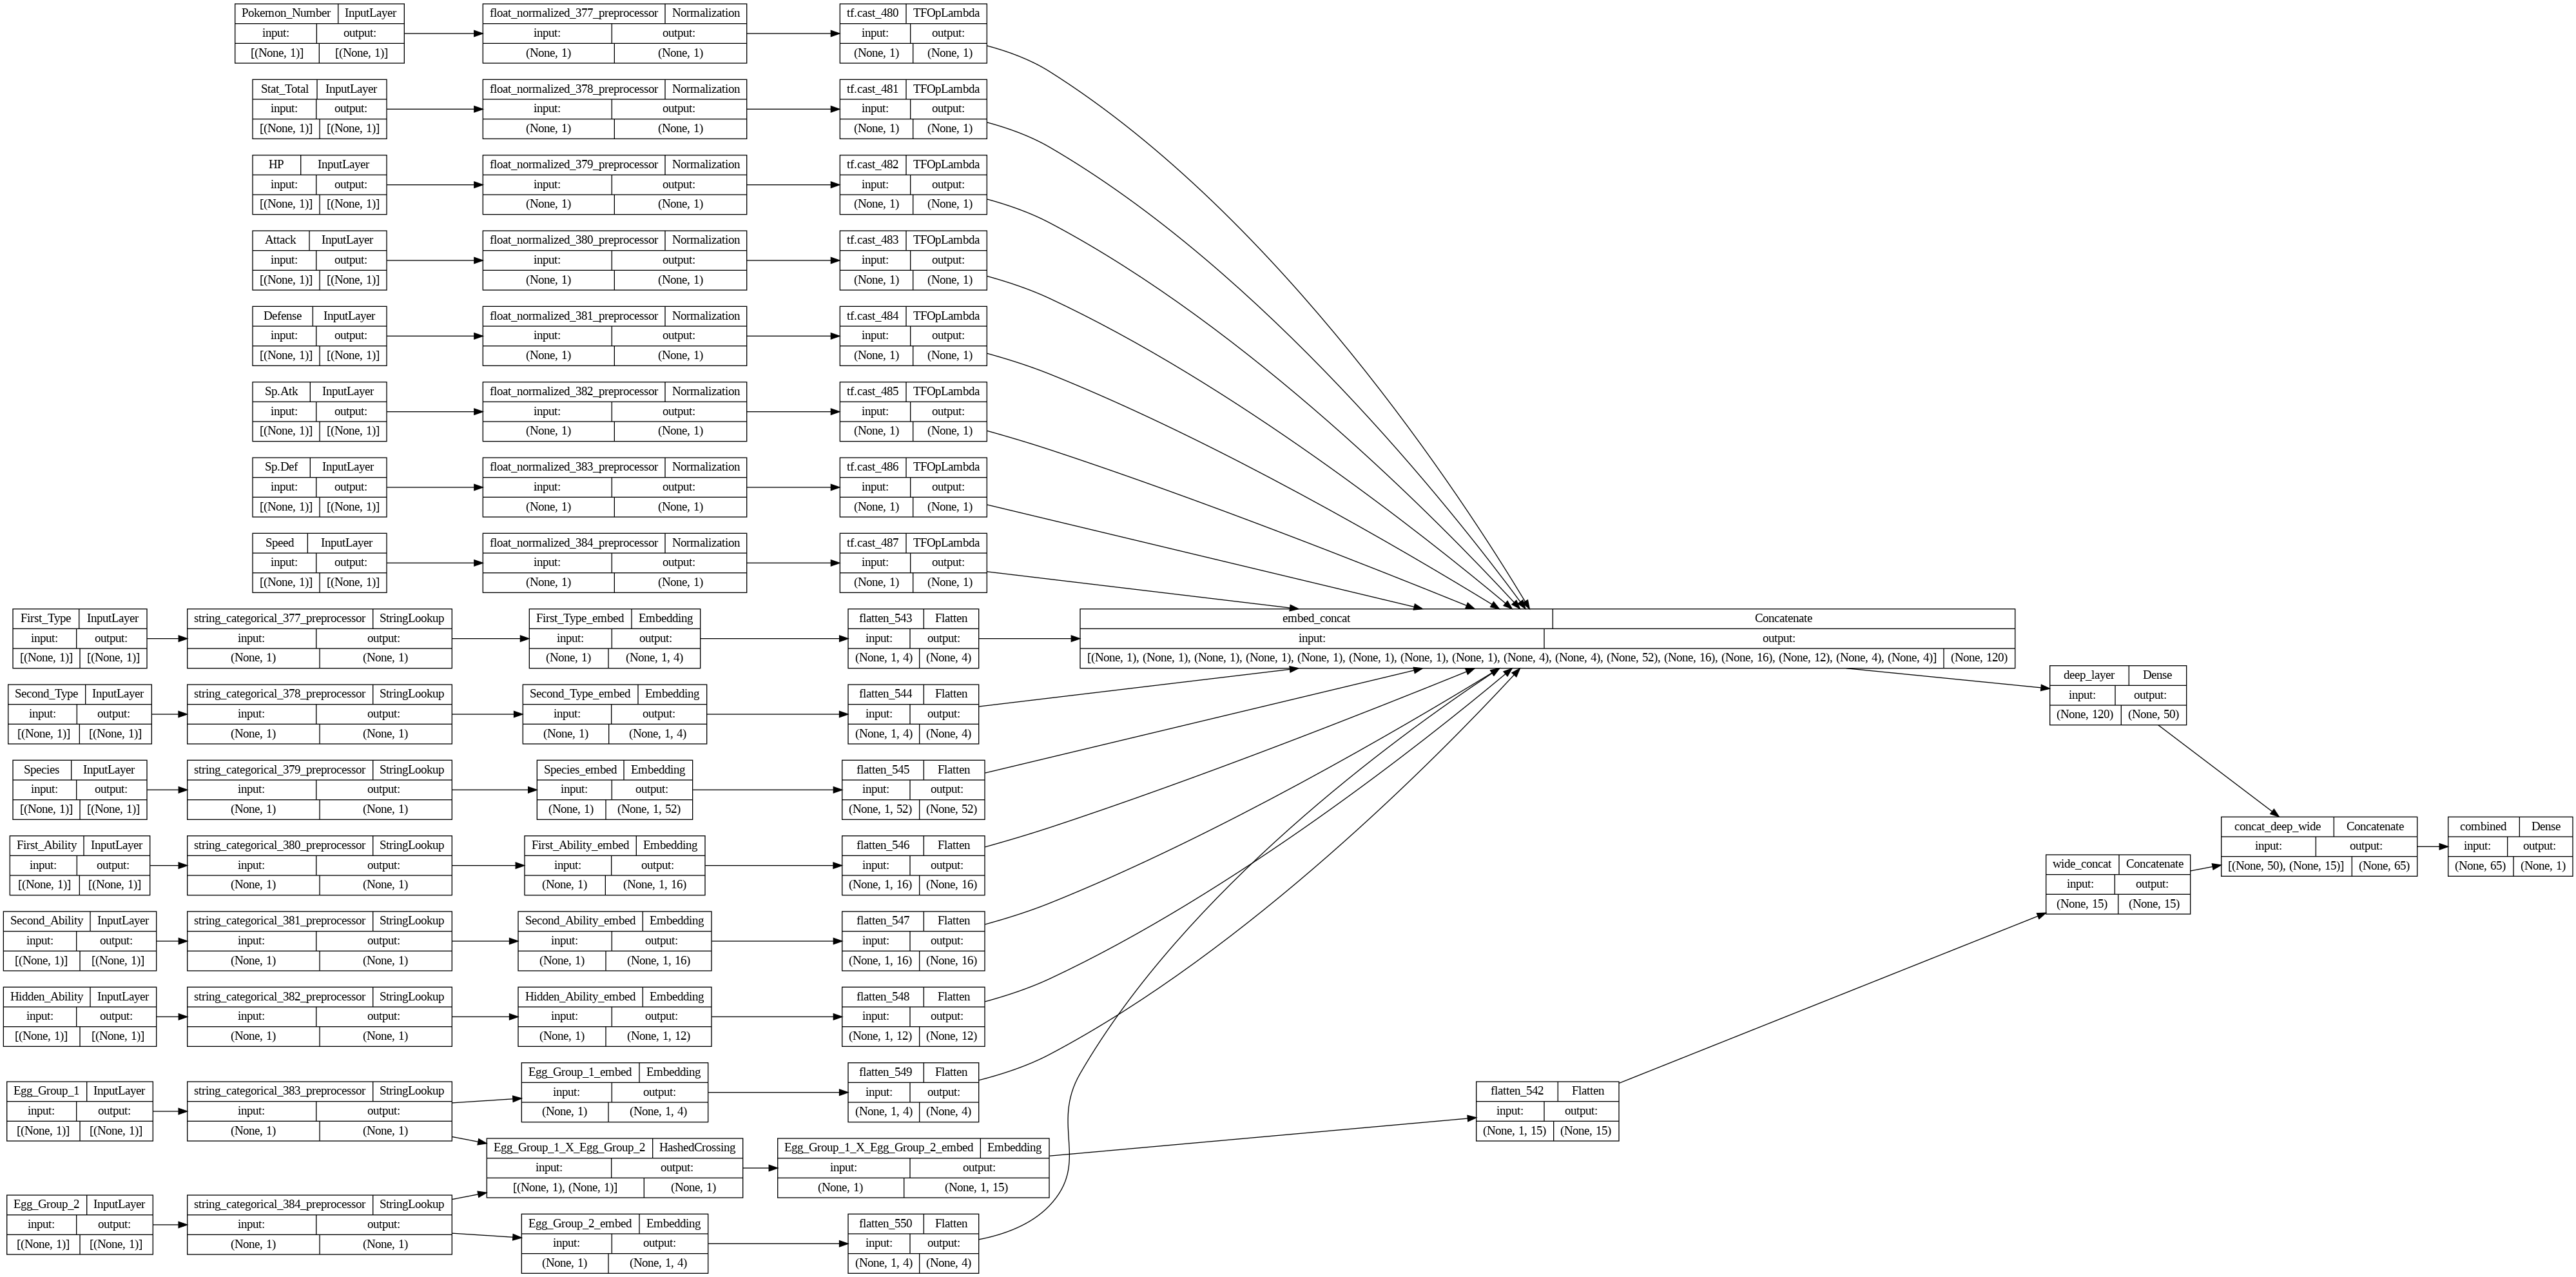

In [772]:
# Optionally, plot the model architecture
plot_model(model_1, to_file='simplified_model.png', show_shapes=True, show_layer_names=True, rankdir='LR', dpi=96)

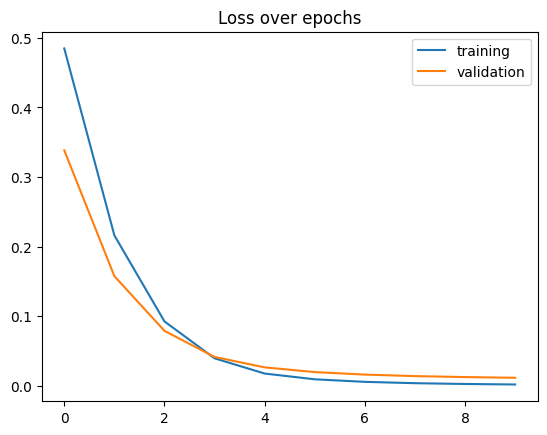

In [773]:
plt.plot(history_shallow.history['loss'],label='training')
plt.plot(history_shallow.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss over epochs')
plt.show()

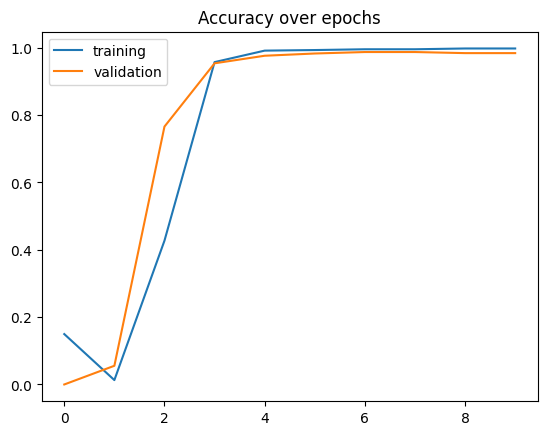

In [774]:
plt.plot(history_shallow.history['f1_score'],label='training')
plt.plot(history_shallow.history['val_f1_score'],label='validation')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

In [775]:
average_train_f1_shallow = sum(history_shallow.history['f1_score']) / len(history_shallow.history['f1_score'])
average_val_f1_shallow = sum(history_shallow.history['val_f1_score']) / len(history_shallow.history['val_f1_score'])

print(f"Average Training F1 Score: {average_train_f1_shallow}")
print(f"Average Validation F1 Score: {average_val_f1_shallow}")

Average Training F1 Score: 0.7519881795160472
Average Validation F1 Score: 0.7678519271314144


Model 2: 5 Layers in Deep Network instead of 3

In [776]:
# Create and compile the model
def create_model(feature_space, numeric_headers, categorical_headers):
    dict_inputs = feature_space.get_inputs()  # Use unprocessed features here to gain access to each output

    # Wide branch with embedded cross features
    crossed_outputs = [setup_embedding_from_crossing(feature_space, col) for col in feature_space.crossers.keys()]
    wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

    # Deep branch with embeddings for categorical variables and raw inputs for numeric variables
    deep_inputs = [tf.cast(feature_space.preprocessors[col].output, float) for col in numeric_headers] + \
                  [setup_embedding_from_categorical(feature_space, col) for col in categorical_headers]
    deep_branch = Concatenate(name='embed_concat')(deep_inputs)

    # Adding 5 layers to the deep branch
    deep_branch = Dense(units=50, activation='relu', name='deep_layer1')(deep_branch)
    deep_branch = Dense(units=50, activation='relu', name='deep_layer2')(deep_branch)
    deep_branch = Dense(units=50, activation='relu', name='deep_layer3')(deep_branch)
    deep_branch = Dense(units=50, activation='relu', name='deep_layer4')(deep_branch)
    deep_branch = Dense(units=50, activation='relu', name='deep_layer5')(deep_branch)

    # Combine deep and wide branches
    final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
    final_branch = Dense(units=1, activation='sigmoid', name='combined')(final_branch)

    # Define the model
    model_5 = keras.Model(inputs=dict_inputs, outputs=final_branch)
    model_5.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[f1_score]
        )
    return model_5

model_5 = create_model(feature_space, numeric_headers, categorical_headers)
model_5.summary()

# Example training call
history_deep = model_5.fit(ds_train, epochs=10, validation_data=ds_test, verbose=1)

# Calculating the average F1 score across all epochs for both training and validation
average_train_f1_deep = sum(history_deep.history['f1_score']) / len(history_deep.history['f1_score'])
average_val_f1_deep = sum(history_deep.history['val_f1_score']) / len(history_deep.history['val_f1_score'])

print(f"Average Training F1 Score: {average_train_f1_deep}")
print(f"Average Validation F1 Score: {average_val_f1_deep}")




Model: "model_70"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 First_Type (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Second_Type (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Species (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 First_Ability (InputLayer)  [(None, 1)]                  0         []                            
                                                                                           

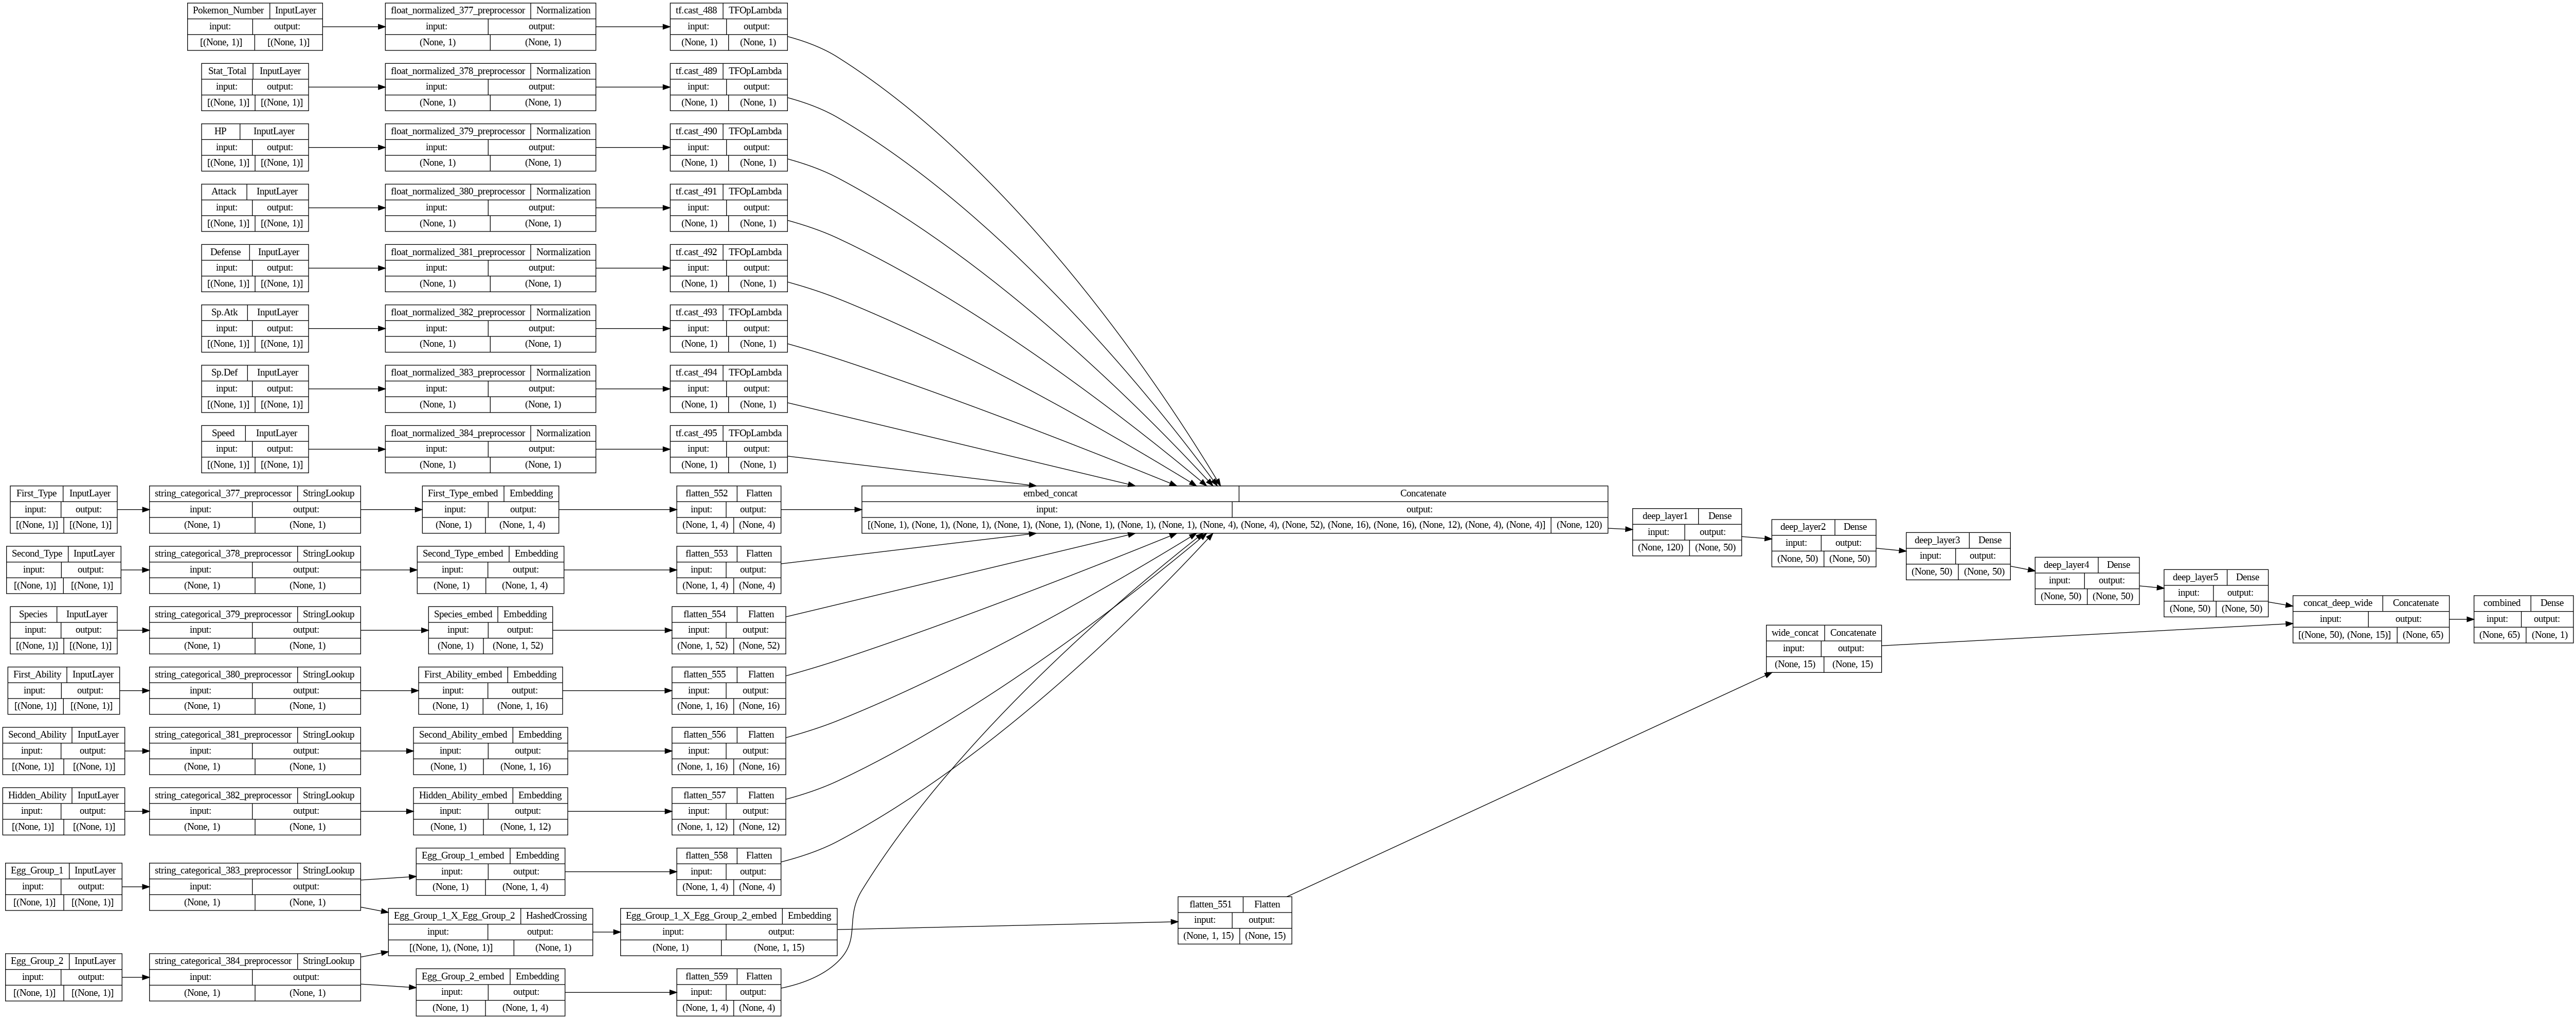

In [777]:
# Optionally, plot the model architecture
plot_model(model_5, to_file='five_layer_model.png', show_shapes=True, show_layer_names=True, rankdir='LR', dpi=96)

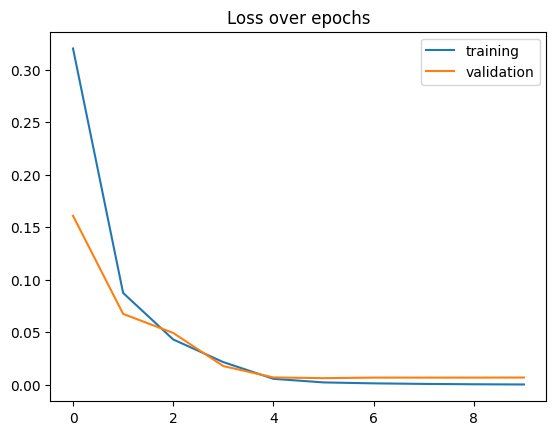

In [778]:
plt.plot(history_deep.history['loss'],label='training')
plt.plot(history_deep.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss over epochs')
plt.show()

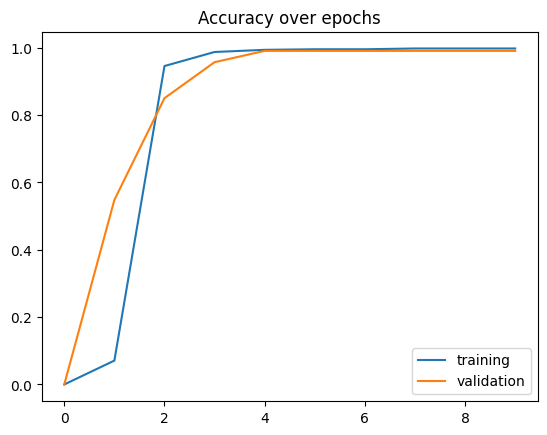

In [779]:
plt.plot(history_deep.history['f1_score'],label='training')
plt.plot(history_deep.history['val_f1_score'],label='validation')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

In [780]:
print(f"Average Training F1 Score 5-Layer: {average_train_f1_deep}")
print(f"Average Validation F1 Score 5-Layer: {average_val_f1_deep}")

Average Training F1 Score 5-Layer: 0.7983910202980041
Average Validation F1 Score 5-Layer: 0.830131596326828


In [781]:
print(f"Average Training F1 Score 1-Layer: {average_train_f1_shallow}")
print(f"Average Validation F1 Score 1-Layer: {average_val_f1_shallow}")

Average Training F1 Score 1-Layer: 0.7519881795160472
Average Validation F1 Score 1-Layer: 0.7678519271314144


From looking at the average training F! score and validation score, the Model with 5 Layers perform the best compared to the model with only 1 layer. Model 2 had an average training f1 score of 0.79 compared to 0.75 for Model 1. Model 2 also had an average validation f1 score of 0.83 comapred to 0.76 for Model 1. Therefore, Model 2, the model with 5 layers, perform the best.

In Conclusion, Model 2 (with Egg Group 1 and Egg Group 2 as its cross columns) with 5 layers is the best model that we have tested so far.

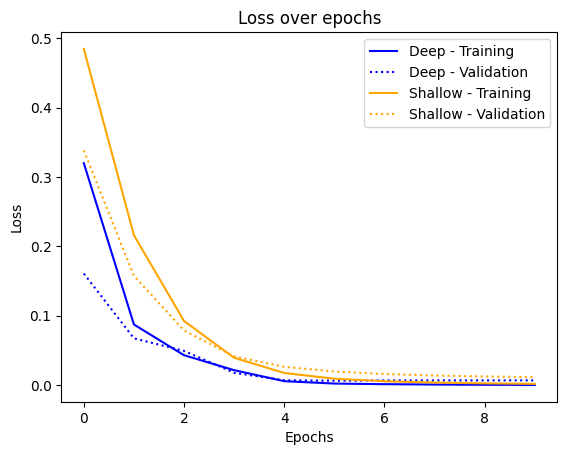

In [782]:
# Deep Model Loss
plt.plot(history_deep.history['loss'], label='5 Layer - Training', color='blue', linestyle='-')
plt.plot(history_deep.history['val_loss'], label='5 Layer - Validation', color='blue', linestyle=':')

# Shallow Model Loss (No Wide Branch)
plt.plot(history_shallow.history['loss'], label='1 Layer - Training', color='orange', linestyle='-')
plt.plot(history_shallow.history['val_loss'], label='1 Layer - Validation', color='orange', linestyle=':')

plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

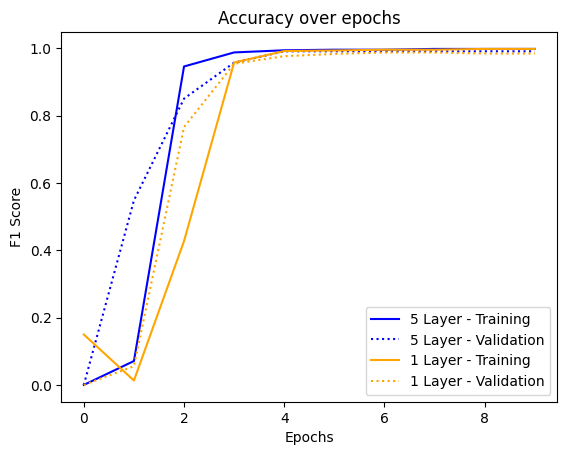

In [838]:
# Deep Model Loss
plt.plot(history_deep.history['f1_score'], label='5 Layer - Training', color='blue', linestyle='-')
plt.plot(history_deep.history['val_f1_score'], label='5 Layer - Validation', color='blue', linestyle=':')

# Shallow Model Loss (No Wide Branch)
plt.plot(history_shallow.history['f1_score'], label='1 Layer - Training', color='orange', linestyle='-')
plt.plot(history_shallow.history['val_f1_score'], label='1 Layer - Validation', color='orange', linestyle=':')

plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

The Graphs above also prove that the Deep Model with 5 layers perform better in terms of f1 score per epoch as well as in average f1 score. The loss per epoch is also less in the Deep Model compared to the Shallow Model, further supporting our conclusion

# 3.2

 Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models.  

 Our best wide and deep network is Model 2 (Egg Group 1 and Egg Group 2 as cross columns) with 5 layers

We will just be deleting the wide part of the network and then evaluating

In [784]:
# Crossing columns together
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "First_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Species": FeatureSpace.string_categorical(num_oov_indices=1),
        "First_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Hidden_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_1": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_2": FeatureSpace.string_categorical(num_oov_indices=1),


        "Pokemon_Number": FeatureSpace.float_normalized(),
        "Stat_Total": FeatureSpace.float_normalized(),
        "HP": FeatureSpace.float_normalized(),
        "Attack": FeatureSpace.float_normalized(),
        "Defense": FeatureSpace.float_normalized(),
        "Sp.Atk": FeatureSpace.float_normalized(),
        "Sp.Def": FeatureSpace.float_normalized(),
        "Speed": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dim
    crosses=[
        #FeatureSpace.cross(
         #   feature_names=('First_Type','Second_Type'), # dims: 7 x 14 =
          #  crossing_dim=18*19),
        #Ability cross takes too much time
        #FeatureSpace.cross(
         #   feature_names=('First_Ability','Second_Ability','Hidden_Ability'), # 7 x 2 x 5
          #  crossing_dim=273*270*165),
        FeatureSpace.cross(
            feature_names=('Egg_Group_1','Egg_Group_2'), # 14 x 16
            crossing_dim=15*16),
    ],
    output_mode="concat",
)

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [806]:
dict_inputs = feature_space.get_inputs()  # need to use unprocessed features here to gain access to each output

# Reset the input branch for the deep branch
all_deep_branch_outputs = []

# For each numeric variable, just add it in after embedding
for idx, col in enumerate(numeric_headers):
    x = feature_space.preprocessors[col].output
    x = tf.cast(x, float)  # cast an integer as a float here
    all_deep_branch_outputs.append(x)

# For each categorical variable
for col in categorical_headers:
    # Get the output tensor from embedding layer
    x = setup_embedding_from_categorical(feature_space, col)
    # Save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

# Merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50, activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50, activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50, activation='relu', name='deep3')(deep_branch)

# Use the output from the deep branch as the final output
final_output = Dense(units=1, activation='sigmoid', name='combined')(deep_branch)

# Create the TensorFlow/Keras model
training_model_no_wide = keras.Model(inputs=dict_inputs, outputs=final_output)
training_model_no_wide.compile(
    optimizer="adagrad",
    loss="mean_squared_error",
    metrics=[f1_score]
)

# Generate a summary and plot of the model
training_model_no_wide.summary()


Model: "model_73"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 First_Type (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 Second_Type (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Species (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 First_Ability (InputLayer)  [(None, 1)]                  0         []                            
                                                                                           

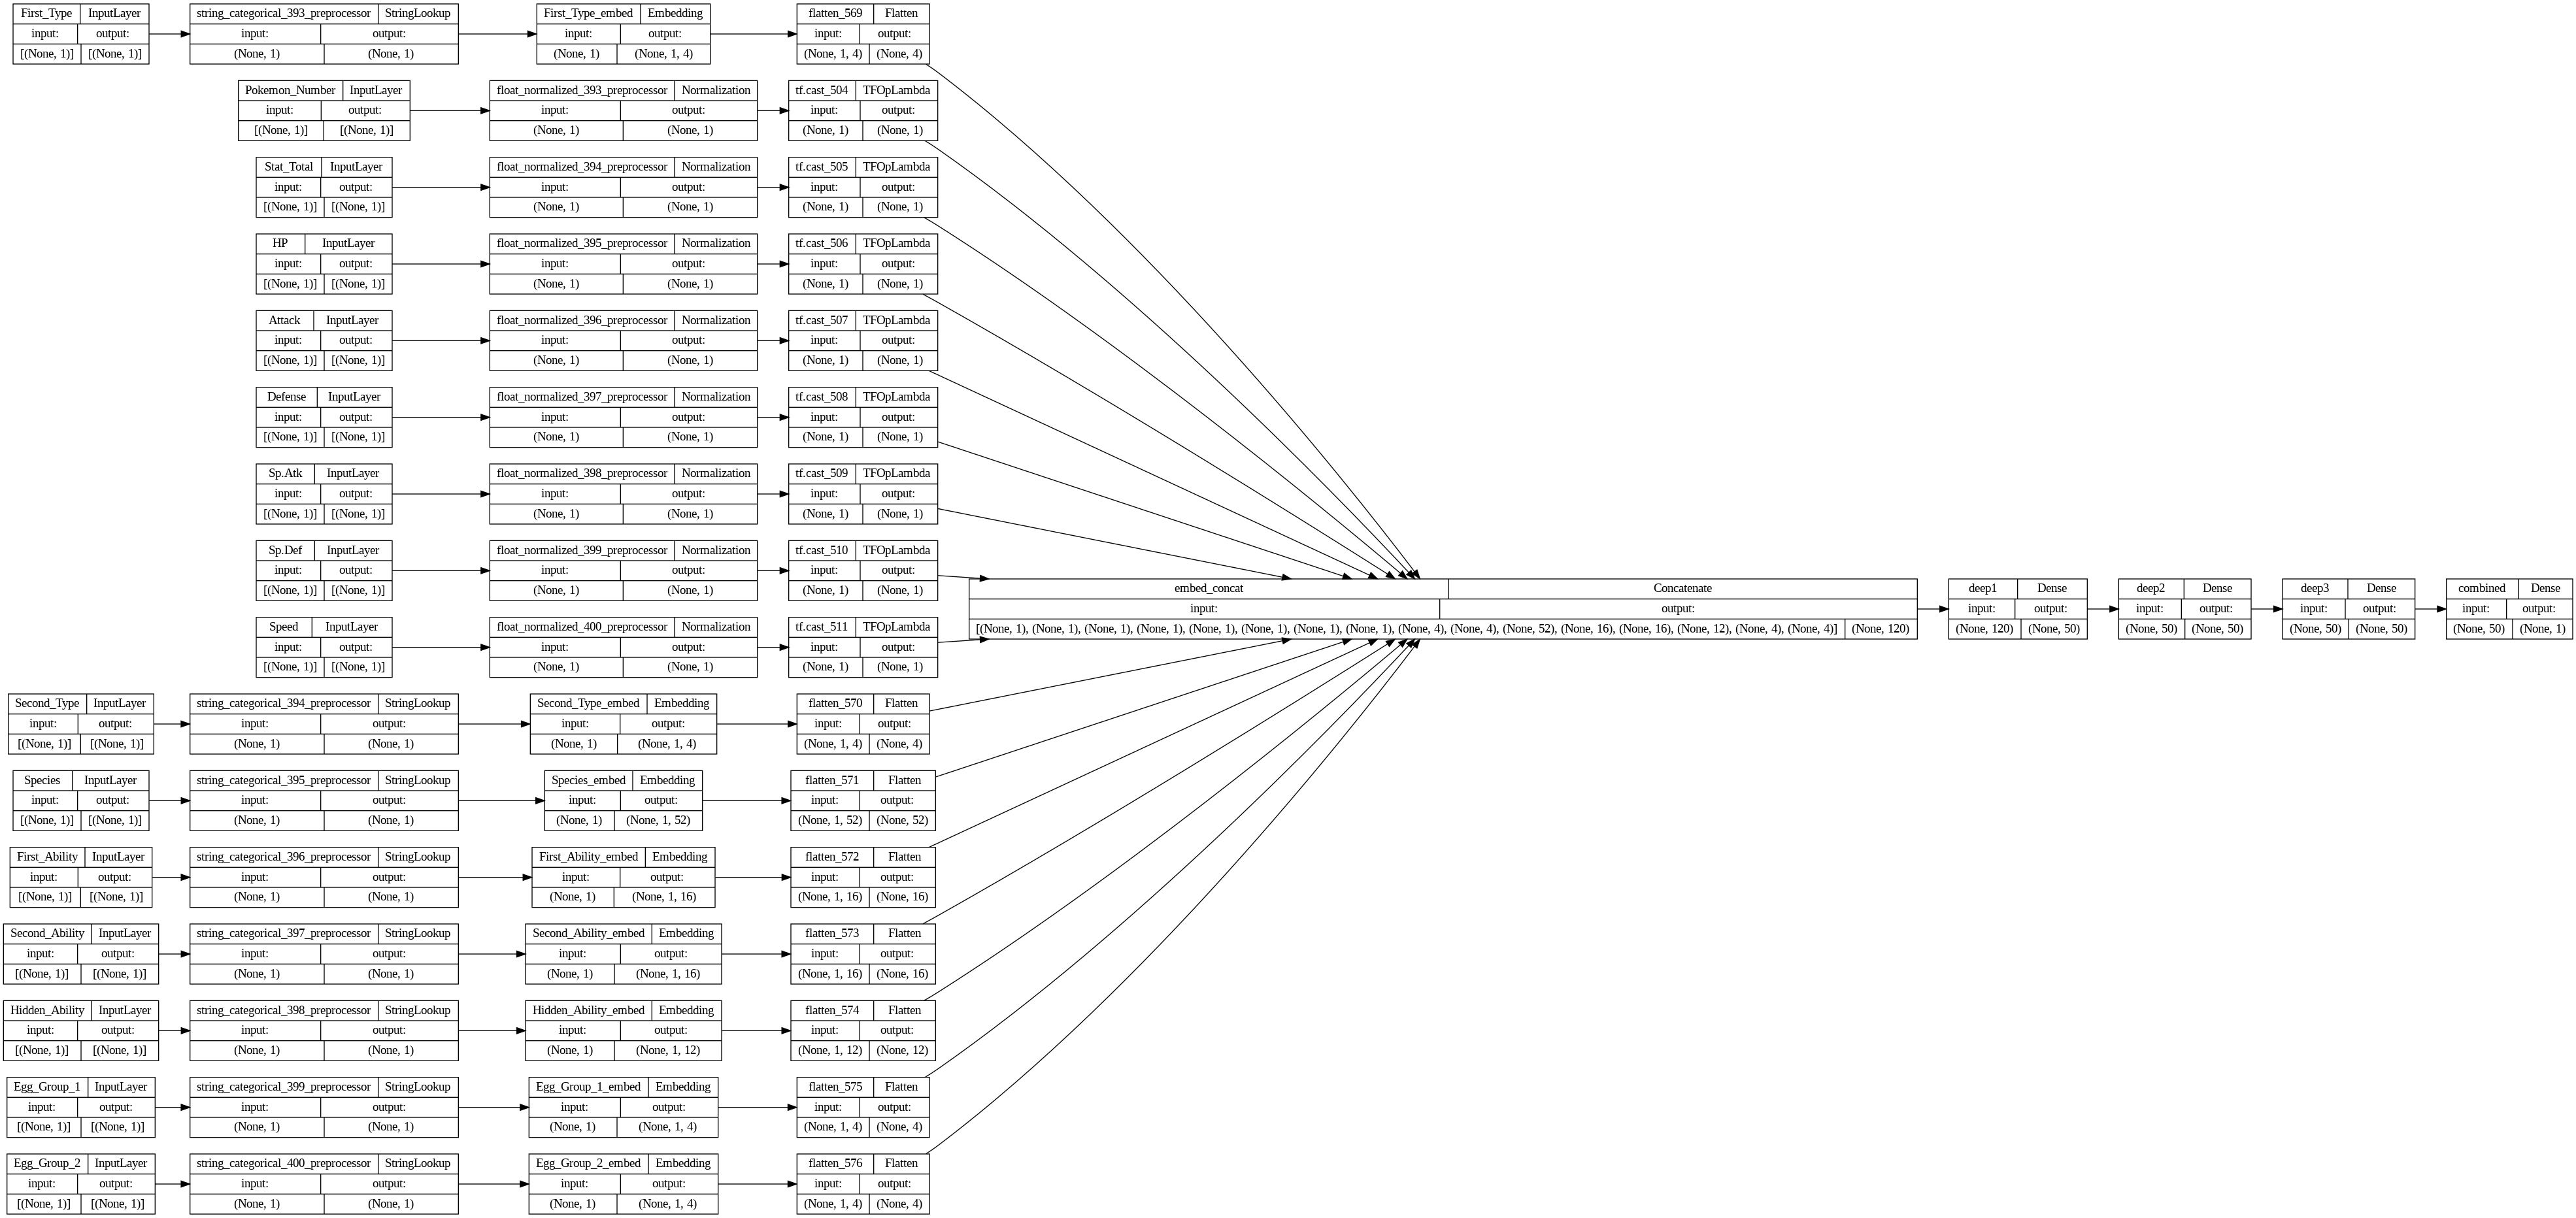

In [807]:
plot_model(
    training_model_no_wide, to_file='deep_only_model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [808]:
history_no_wide = training_model_no_wide.fit(
    ds_train, epochs=10, validation_data=ds_test, verbose=2
)

Epoch 1/10
39/39 - 2s - loss: 0.2676 - f1_score: 0.1188 - val_loss: 0.2612 - val_f1_score: 0.1568 - 2s/epoch - 48ms/step
Epoch 2/10
39/39 - 0s - loss: 0.2575 - f1_score: 0.1294 - val_loss: 0.2525 - val_f1_score: 0.1800 - 139ms/epoch - 4ms/step
Epoch 3/10
39/39 - 0s - loss: 0.2490 - f1_score: 0.1266 - val_loss: 0.2448 - val_f1_score: 0.1408 - 138ms/epoch - 4ms/step
Epoch 4/10
39/39 - 0s - loss: 0.2412 - f1_score: 0.0875 - val_loss: 0.2377 - val_f1_score: 0.0973 - 135ms/epoch - 3ms/step
Epoch 5/10
39/39 - 0s - loss: 0.2340 - f1_score: 0.0249 - val_loss: 0.2310 - val_f1_score: 0.0686 - 155ms/epoch - 4ms/step
Epoch 6/10
39/39 - 0s - loss: 0.2272 - f1_score: 0.0127 - val_loss: 0.2247 - val_f1_score: 0.0354 - 143ms/epoch - 4ms/step
Epoch 7/10
39/39 - 0s - loss: 0.2207 - f1_score: 0.0000e+00 - val_loss: 0.2187 - val_f1_score: 0.0000e+00 - 145ms/epoch - 4ms/step
Epoch 8/10
39/39 - 0s - loss: 0.2145 - f1_score: 0.0000e+00 - val_loss: 0.2129 - val_f1_score: 0.0000e+00 - 139ms/epoch - 4ms/step
Ep

In [809]:
average_train_f1_no_wide = sum(history_no_wide.history['f1_score']) / len(history_no_wide.history['f1_score'])
average_val_f1_no_wide = sum(history_no_wide.history['val_f1_score']) / len(history_no_wide.history['val_f1_score'])

print(f"Average Training F1 Score: {average_train_f1_no_wide}")
print(f"Average Validation F1 Score: {average_val_f1_no_wide}")

Average Training F1 Score: 0.05000018617138267
Average Validation F1 Score: 0.06788831986486912


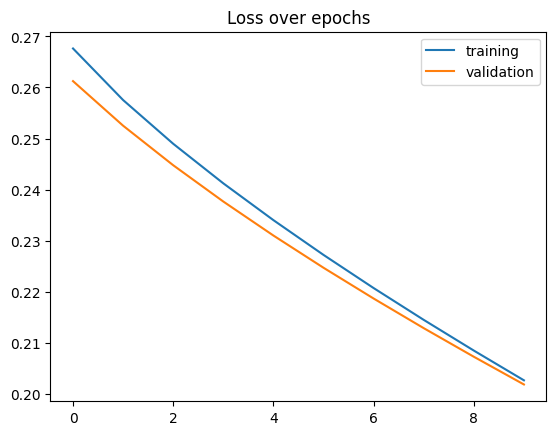

In [810]:
plt.plot(history_no_wide.history['loss'],label='training')
plt.plot(history_no_wide.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss over epochs')
plt.show()

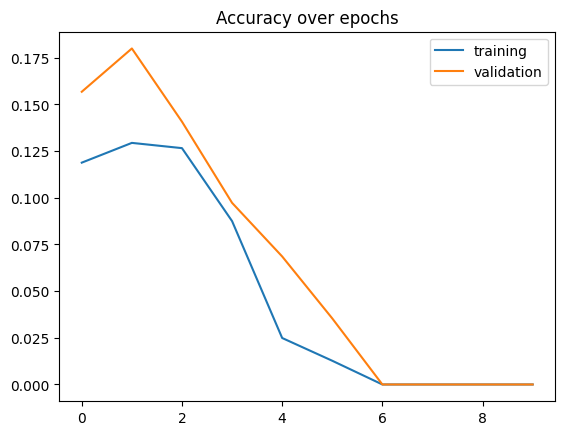

In [811]:
plt.plot(history_no_wide.history['f1_score'],label='training')
plt.plot(history_no_wide.history['val_f1_score'],label='validation')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

Classification comparision using reciever operating characteristic and area under the curve

In [826]:
# Assuming ds_test is your testing dataset and is the same for both models
y_pred_no_wide = training_model_no_wide.predict(ds_train)
y_pred_deep = model_5.predict(ds_train)

# Since ds_test includes data in batches, ensure your labels are also retrieved in a similar structure if not done already:
y_true = np.concatenate([y for x, y in ds_train], axis=0)


39/39 [==============================] - 0s 3ms/step


In [827]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC for both models
fpr_no_wide, tpr_no_wide, thresholds_no_wide = roc_curve(y_true, y_pred_no_wide)
fpr_deep, tpr_deep, thresholds_deep = roc_curve(y_true, y_pred_deep)

auc_no_wide = auc(fpr_no_wide, tpr_no_wide)
auc_deep = auc(fpr_deep, tpr_deep)

print("AUC for No Wide Network: {:.3f}".format(auc_no_wide))
print("AUC for Deep Network: {:.3f}".format(auc_deep))


AUC for No Wide Network: 0.223
AUC for Deep Network: 1.000


In [828]:
from sklearn.metrics import roc_auc_score
from scipy.stats import sem

# Function to calculate the standard error of the mean
def compare_auc_delong(y_true, y_scores1, y_scores2):
    auc1 = roc_auc_score(y_true, y_scores1)
    auc2 = roc_auc_score(y_true, y_scores2)
    se_auc1 = sem(y_scores1)
    se_auc2 = sem(y_scores2)
    z_stat = (auc1 - auc2) / np.sqrt(se_auc1**2 + se_auc2**2)
    p_val = np.exp(-0.717 * z_stat - 0.416 * z_stat**2)
    return auc1, auc2, p_val

# Compare AUC scores statistically
auc1, auc2, p_val = compare_auc_delong(y_true, y_pred_no_wide.flatten(), y_pred_deep.flatten())
print("AUC1 (No Wide): {:.3f}, AUC2 (Deep): {:.3f}, p-value: {:.3f}".format(auc1, auc2, p_val))


AUC1 (No Wide): 0.223, AUC2 (Deep): 1.000, p-value: 0.000


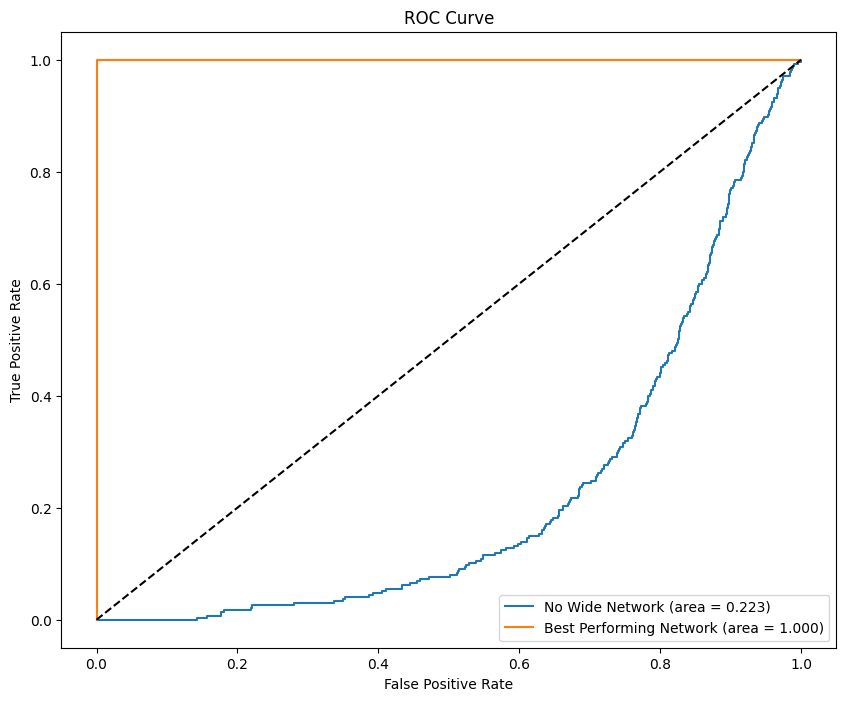

In [837]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(fpr_no_wide, tpr_no_wide, label='No Wide Network (area = {:.3f})'.format(auc_no_wide))
plt.plot(fpr_deep, tpr_deep, label='Best Performing Network (area = {:.3f})'.format(auc_deep))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


As you can see, while our best model (the Deep Network) has the ideal line, the Network without the Wide part never crosses the random guessing line, showing that removing the Wide part causes performance to drop dramatically. Therefore, we can conclude that Model 2 (using Egg Group 1 and Egg Group 2 as Cross Columns) is still the best network

# Exceptional Work

Instead of removing the wide branch, we will be removing the deep branch instead.

In [830]:
# Crossing columns together
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "First_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Type": FeatureSpace.string_categorical(num_oov_indices=1),
        "Species": FeatureSpace.string_categorical(num_oov_indices=1),
        "First_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Second_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Hidden_Ability": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_1": FeatureSpace.string_categorical(num_oov_indices=1),
        "Egg_Group_2": FeatureSpace.string_categorical(num_oov_indices=1),


        "Pokemon_Number": FeatureSpace.float_normalized(),
        "Stat_Total": FeatureSpace.float_normalized(),
        "HP": FeatureSpace.float_normalized(),
        "Attack": FeatureSpace.float_normalized(),
        "Defense": FeatureSpace.float_normalized(),
        "Sp.Atk": FeatureSpace.float_normalized(),
        "Sp.Def": FeatureSpace.float_normalized(),
        "Speed": FeatureSpace.float_normalized(),
    },
    # Specify feature cross with a custom crossing dim
    crosses=[
        #FeatureSpace.cross(
         #   feature_names=('First_Type','Second_Type'), # dims: 7 x 14 =
          #  crossing_dim=18*19),
        #Ability cross takes too much time
        #FeatureSpace.cross(
         #   feature_names=('First_Ability','Second_Ability','Hidden_Ability'), # 7 x 2 x 5
          #  crossing_dim=273*270*165),
        FeatureSpace.cross(
            feature_names=('Egg_Group_1','Egg_Group_2'), # 14 x 16
            crossing_dim=15*16),
    ],
    output_mode="concat",
)

# add explanation of this pre-processing here
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [816]:
dict_inputs = feature_space.get_inputs()  # need to use unprocessed features here to gain access to each output

# We need to create separate lists for each branch
crossed_outputs = []

# For each crossed variable, make an embedding and save these outputs in list to concatenate later
for col in feature_space.crossers.keys():
    x = setup_embedding_from_crossing(feature_space, col)
    crossed_outputs.append(x)

# Now concatenate the outputs from the wide branch and use this as the input to the final output layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)
final_output = Dense(units=1, activation='sigmoid', name='combined')(wide_branch)

# Create the TensorFlow/Keras model
training_model_no_deep = keras.Model(inputs=dict_inputs, outputs=final_output)
training_model_no_deep.compile(
    optimizer="adagrad",
    loss="mean_squared_error",
    metrics=[f1_score]
)

# Generate a summary and plot of the model
training_model_no_deep.summary()


Model: "model_74"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Egg_Group_1 (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 Egg_Group_2 (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 string_categorical_399_pre  (None, 1)                    0         ['Egg_Group_1[0][0]']         
 processor (StringLookup)                                                                         
                                                                                                  
 string_categorical_400_pre  (None, 1)                    0         ['Egg_Group_2[0][0]']  

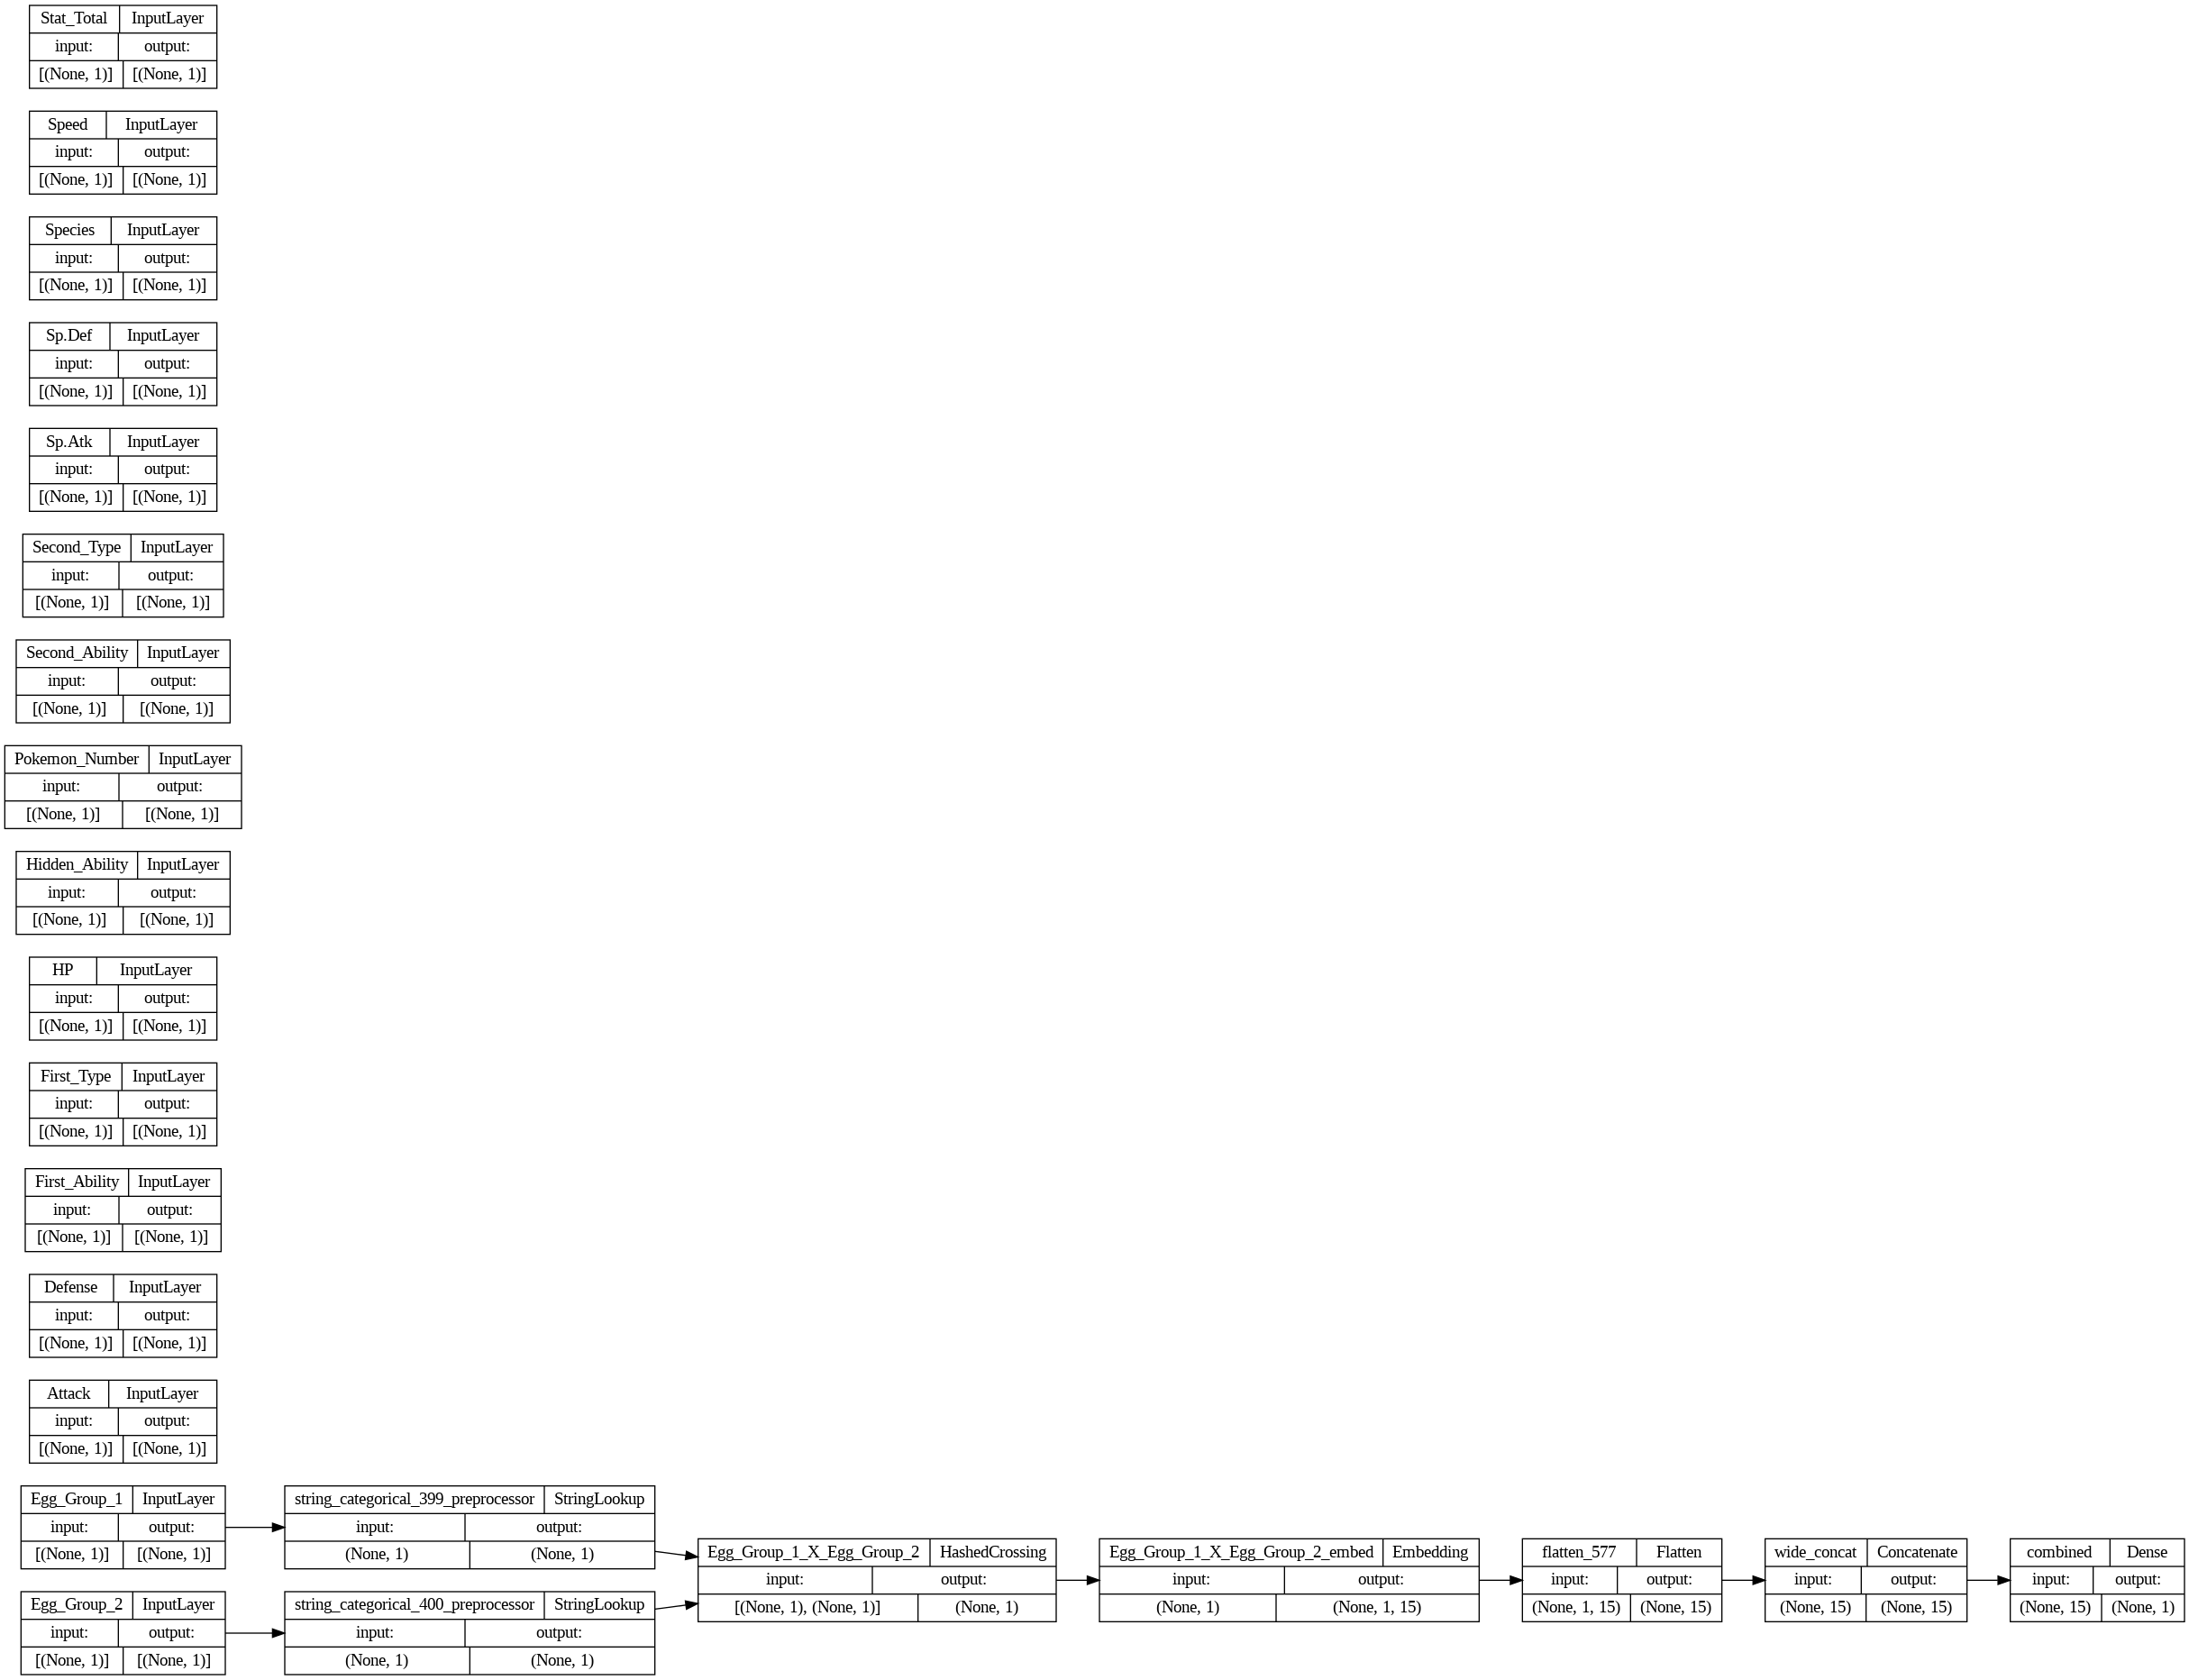

In [817]:
plot_model(
    training_model_no_deep, to_file='wide_only_model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [818]:
history = training_model_no_deep.fit(
    ds_train, epochs=10, validation_data=ds_test, verbose=1
)

Epoch 1/10
39/39 [==============================] - 2s 8ms/step - loss: 0.2474 - f1_score: 0.1691 - val_loss: 0.2463 - val_f1_score: 0.2197
Epoch 2/10
39/39 [==============================] - 0s 3ms/step - loss: 0.2456 - f1_score: 0.1774 - val_loss: 0.2449 - val_f1_score: 0.2326
Epoch 3/10
39/39 [==============================] - 0s 3ms/step - loss: 0.2443 - f1_score: 0.1867 - val_loss: 0.2438 - val_f1_score: 0.2395
Epoch 4/10
39/39 [==============================] - 0s 3ms/step - loss: 0.2432 - f1_score: 0.2003 - val_loss: 0.2427 - val_f1_score: 0.2957
Epoch 5/10
39/39 [==============================] - 0s 3ms/step - loss: 0.2422 - f1_score: 0.2512 - val_loss: 0.2418 - val_f1_score: 0.3417
Epoch 6/10
39/39 [==============================] - 0s 3ms/step - loss: 0.2412 - f1_score: 0.2605 - val_loss: 0.2409 - val_f1_score: 0.3446
Epoch 7/10
39/39 [==============================] - 0s 3ms/step - loss: 0.2404 - f1_score: 0.2643 - val_loss: 0.2401 - val_f1_score: 0.3546
Epoch 8/10
39/39 [==

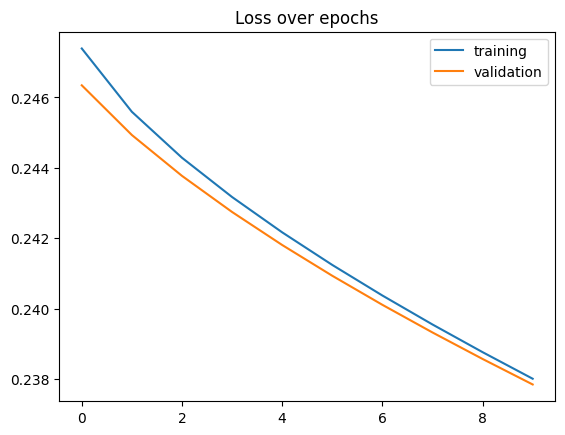

In [819]:
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.legend()
plt.title('Loss over epochs')
plt.show()

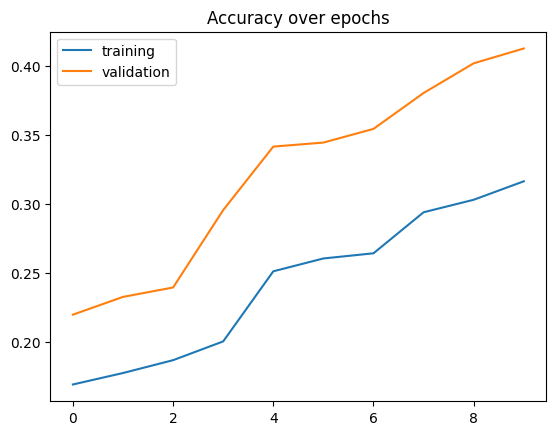

In [820]:
plt.plot(history.history['f1_score'],label='training')
plt.plot(history.history['val_f1_score'],label='validation')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

In [821]:
average_train_f1_no_deep = sum(history.history['f1_score']) / len(history.history['f1_score'])
average_val_f1_no_deep = sum(history.history['val_f1_score']) / len(history.history['val_f1_score'])

print(f"Average Training F1 Score: {average_train_f1_no_deep}")
print(f"Average Validation F1 Score: {average_val_f1_no_deep}")

Average Training F1 Score: 0.24232205450534822
Average Validation F1 Score: 0.3224198192358017


As you can see, removing the deep part of the network also dramatically decreases the accuracy.

In [831]:
y_pred_no_deep = training_model_no_deep.predict(ds_train)
y_pred_deep = model_5.predict(ds_train)

# Since ds_test includes data in batches, ensure your labels are also retrieved in a similar structure if not done already:
y_true = np.concatenate([y for x, y in ds_train], axis=0)

39/39 [==============================] - 0s 4ms/step


In [832]:
# Calculate the ROC curve and AUC for both models
fpr_no_deep, tpr_no_deep, thresholds_no_deep = roc_curve(y_true, y_pred_no_deep)
fpr_deep, tpr_deep, thresholds_deep = roc_curve(y_true, y_pred_deep)

auc_no_deep = auc(fpr_no_deep, tpr_no_deep)
auc_deep = auc(fpr_deep, tpr_deep)

print("AUC for No Wide Network: {:.3f}".format(auc_no_wide))
print("AUC for Deep Network: {:.3f}".format(auc_deep))


AUC for No Wide Network: 0.223
AUC for Deep Network: 1.000


In [833]:
auc1, auc2, p_val = compare_auc_delong(y_true, y_pred_no_deep.flatten(), y_pred_deep.flatten())
print("AUC1 (No Wide): {:.3f}, AUC2 (Deep): {:.3f}, p-value: {:.3f}".format(auc1, auc2, p_val))

AUC1 (No Wide): 0.756, AUC2 (Deep): 1.000, p-value: 0.000


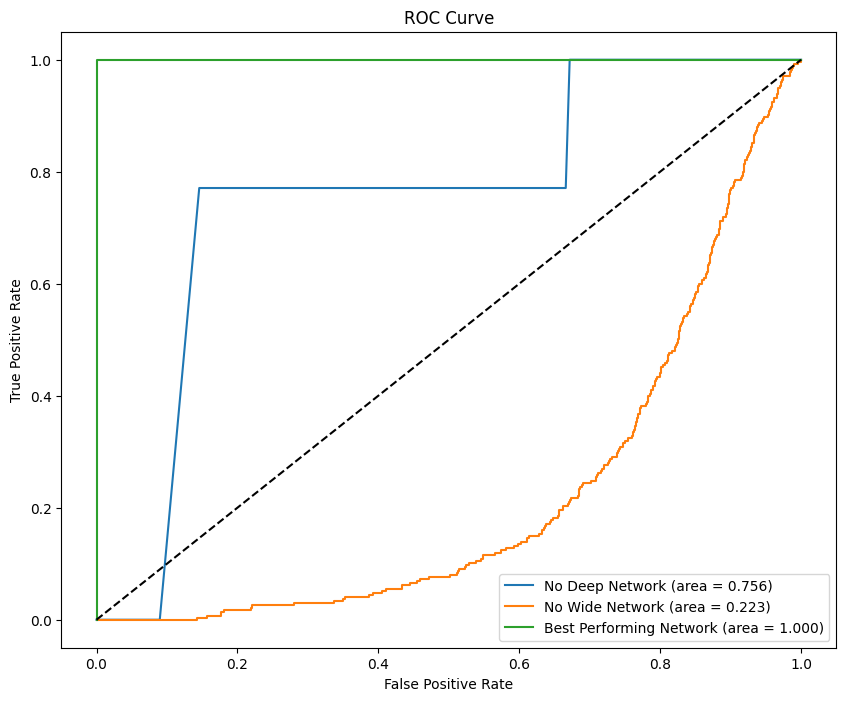

In [836]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_no_deep, tpr_no_deep, label='No Deep Network (area = {:.3f})'.format(auc_no_deep))
plt.plot(fpr_no_wide, tpr_no_wide, label='No Wide Network (area = {:.3f})'.format(auc_no_wide))
plt.plot(fpr_deep, tpr_deep, label='Best Performing Network (area = {:.3f})'.format(auc_deep))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

Similar to the graph with the Deep Network and the No Wide Network, here, the Deep Network still has the ideal line, while the No Deep Network initially starts off beneath the random guessing line before crossing it. This shows that removing the Deep part of the network, while it does decrease performance, it doesn't impact performance nearly as much as removing the Wide part of the network. From here, we can concluse that cutting out either the Deep part or the wide part of the network decreases performance.